In [16]:
'''Line up the peak (by offsetting the peak,
or just throw away data before the peak) --DONE
Filter out data with large gap --DONE
Data with only 80-120 phyisical days after peak
Input more parameters for learning
Distribution (frequency vs neuron score) --DONE
Use the maximum date as input --DONE
Weighted loss
Labeling the lightcurve for different type of supernova --DONE
Interpolation that taken account in the non-uniform timestep? --DONE
Feed the output back as input to see anything reasonable --DONE
Throw away data without a rising peak (calculate the average nemerical slope before the maximum) --DONE
Truncate the no. of days --DONE
Try using relative physical date as input (don't need to interpolate for uniform step in this way?) --DONE
Smoothing the interpolation by taking average
Just use one telescope? --DONE
Try multiple band?
See see the output from the encoding part --DONE
Philips relation from the output --DONE
Dropout layer (much worse learning as predicted) --DONE
Training and predicting with lightcurve with large data gaps'''

"Line up the peak (by offsetting the peak,\nor just throw away data before the peak) --DONE\nFilter out data with large gap --DONE\nData with only 80-120 phyisical days after peak\nInput more parameters for learning\nDistribution (frequency vs neuron score) --DONE\nUse the maximum date as input --DONE\nWeighted loss\nLabeling the lightcurve for different type of supernova --DONE\nInterpolation that taken account in the non-uniform timestep? --DONE\nFeed the output back as input to see anything reasonable --DONE\nThrow away data without a rising peak (calculate the average nemerical slope before the maximum) --DONE\nTruncate the no. of days --DONE\nTry using relative physical date as input (don't need to interpolate for uniform step in this way?) --DONE\nSmoothing the interpolation by taking average\nJust use one telescope? --DONE\nTry multiple band?\nSee see the output from the encoding part --DONE\nPhilips relation from the output --DONE\nDropout layer (much worse learning as predicte

In [17]:
import os
import glob
import numpy as np
import pandas as pd
import json
import math
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline, interp1d, splrep

import keras
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout, Layer, Bidirectional, Conv1D, Flatten
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from keras.optimizers import Adam
import keras.backend as K
import tensorflow as tf

In [18]:
# Import the .json file

os.chdir(r"C:\Users\ricky\JupyterNotebooks\Intern21\import_photometry_data\all_photometry")
filename = glob.glob('*.json')
np.random.seed(1)
np.random.shuffle(filename)
print(filename)

# Create a list for all .json, the 1st SN saved as json_data[0], the 2nd SN saved as json_data[1], etc.
json_data = []
for i in filename:
    with open(i, encoding="utf-8") as f:
        json_data.append(json.load(f))

['SN2005am.json', 'SN2016hvl.json', 'SN2009E.json', 'SN2015V.json', 'SN2004et.json', 'SN2003B.json', 'SN2007sr.json', 'SN2004gs.json', 'SN2013ft.json', 'SN2011fe.json', 'SN2016X.json', 'SN2003cg.json', 'SN2013gy.json', 'SN2017eaw.json', 'SN2015F.json', 'SN2018bac.json', 'SN1969L.json', 'SN2012hr.json', 'SN2016dxj.json', 'SN2005cs.json', 'SN2007od.json', 'SN2010F.json', 'SN2011by.json', 'SN1999cr.json', 'SN2012aw.json', 'SN2005ki.json', 'SN2003gd.json', 'SN2008hs.json', 'SN2012fr.json', 'SN2013gh.json', 'SN2010aj.json', 'SN2004dj.json', 'SN2014cn.json', 'SN2005na.json', 'SN2005hc.json', 'SN2004eo.json', 'SN2007hv.json', 'SN2006D.json', 'SN1990N.json', 'SN2016esw.json', 'SN2003bn.json', 'SN2011ef.json', 'SN2003hn.json', 'SN1999em.json', 'SN2019kg.json', 'SN2002fk.json', 'SN2003hg.json', 'SN2006ax.json', 'SN2003iq.json', 'SN2009ib.json', 'SN2013aa.json', 'SN2013bu.json', 'SN2003Z.json', 'SN2006le.json', 'SN2007on.json', 'SN2012ht.json', 'SN2000E.json', 'SN2003du.json', 'SN2017drh.json', '

In [19]:
'''To obtain absolute magnitude and time in a particular band.
For every SN.json, there may be multiple sources even within one light band,
at the end this cell will return a list of time and magnitude for every source of the same band'''

Band = [] # Contain EM band chosen for analysis
Magnitude_Abs = [] # Contain absolute magnitude
Time = [] # Contain time (day)
Type = [] # Claimed type
Sample_Count = 0 # Number of light curves obtained


for i in range(len(filename)): # Loop through all SN

    Source = [] # Contain different sources within a single .json
    
    Band.append([]) # Create 2D list
    
    SN_name = filename[i].replace('.json', '')
    SN_name = SN_name.replace('_', ':')
    
    LumDist = float(json_data[i][SN_name]['lumdist'][0]['value']) # Obtain the luminosity distance
    
    z = float(json_data[i][SN_name]['redshift'][0]['value']) # Obtain the redshift, z
    
    N = len(json_data[i][SN_name]['photometry']) # The no. of data point of photometry in each SN

    for j in range(N): # Loop through all photemetry datapoint in one SN
        # Avoid any data point without band data
        try:
            Band[i].append(json_data[i][SN_name]['photometry'][j]['band'])
        except:
            Band[i].append(0)
        
        # Fill the Magnitude_Abs and Time list if the data point is in B band
        if Band[i][j] == 'B':
            
            Source.append(json_data[i][SN_name]['photometry'][j]['source']) # Obtain the sources
            Source = list(set(Source)) # Remove repetitive sources
            
    if len(Source) == 0: # Avoid empty sources
        Source.append('0') 
        
    
    # Create light curves for every sources
    for k in range(len(Source)):
        
        Type.append(json_data[i][SN_name]['claimedtype'][0]['value'])
        
        for j in range(N): # Loop through all photemetry datapoint in one source
            if (Band[i][j] == 'B') & (json_data[i][SN_name]['photometry'][j]['source'] == Source[k]):
                Magnitude_App = float(json_data[i][SN_name]['photometry'][j]['magnitude']) # Obtain the apparent magnitude from photometry
                
                Magnitude_Abs.append([]) # Create 2D list
                Time.append([])
                
                Magnitude_Abs[Sample_Count].append(Magnitude_App - 5*np.log10(LumDist*1e5) + 2.5*np.log10(1+z)) # Calculate the absolute magnitude and fill the Magnitude_Abs list
                Time[Sample_Count].append(float(json_data[i][SN_name]['photometry'][j]['time'])) # Fill the Time list
                
        Sample_Count += 1
    
    #print(Source)
print(Sample_Count)
print(len(filename))

343
122


The maximum lightcurve length is 130
[3, 6, 18, 19, 21, 22, 24, 28, 34, 39, 42, 57, 61, 64, 75, 76, 105, 108, 112, 131, 135, 136, 139, 140, 143, 150, 164, 171, 172, 190, 209, 219, 221, 223, 224, 228, 231, 235, 253, 260, 261, 262, 291]
[50, 44, 122, 53, 59, 25, 108, 49, 61, 37, 54, 43, 31, 36, 90, 80, 32, 32, 36, 49, 22, 22, 16, 37, 58, 73, 24, 42, 42, 29, 84, 129, 32, 19, 59, 44, 43, 64, 27, 71, 34, 76, 21]
43 43
No. of data is 43
50 Ia


<ipython-input-20-7937145b8649>:27: RuntimeWarning: divide by zero encountered in double_scalars
  slope += (Magnitude_Abs[i][j+1] - Magnitude_Abs[i][j]) / (Time[i][j+1] - Time[i][j]) # Calculate the average slope between 1st and 4th data point to select out data with rising peak only


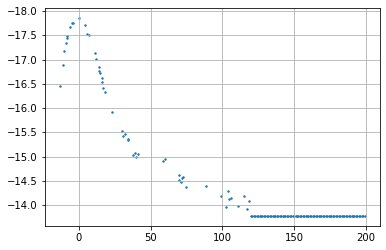

44 II P


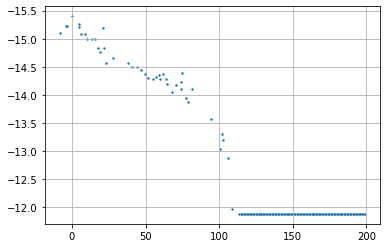

122 Ia


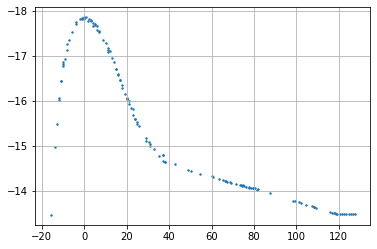

53 Ia


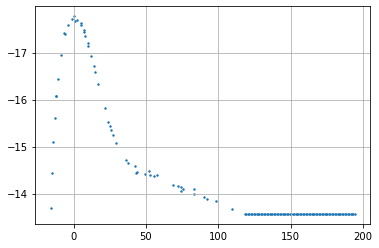

59 Ia


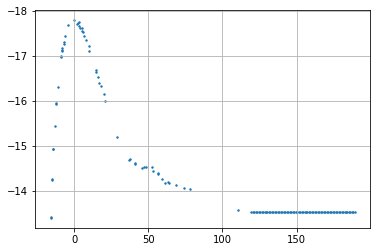

25 Ia


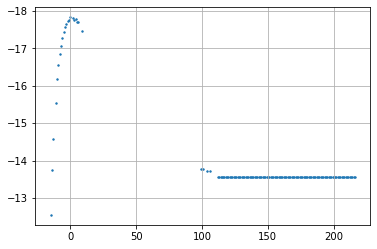

108 II P


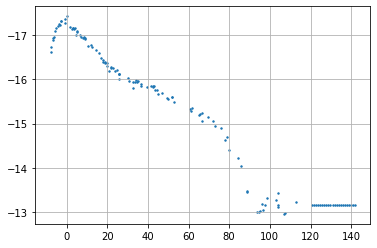

49 Ia


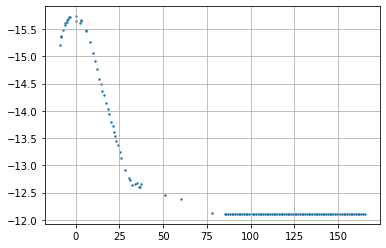

61 II P


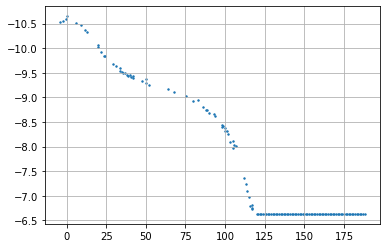

37 II


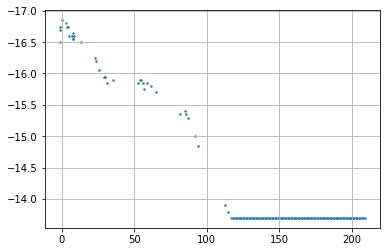

54 II


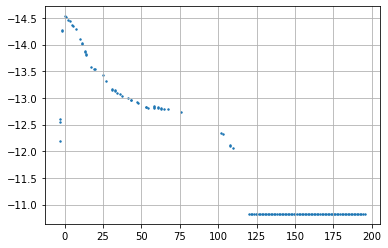

43 II P


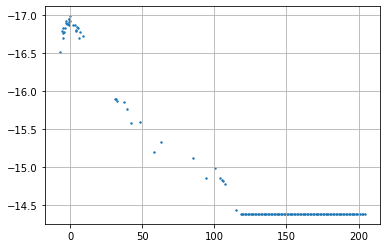

31 II P


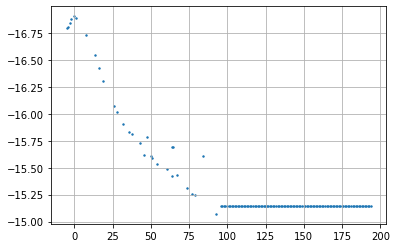

36 Ia


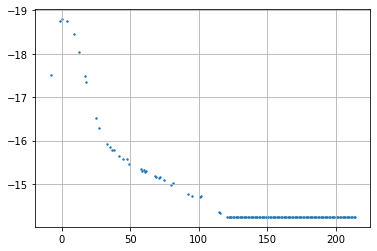

90 Ia


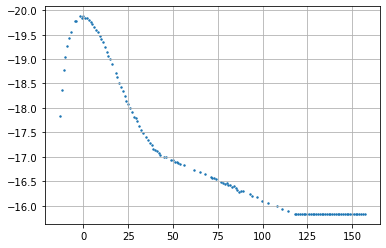

80 Ia


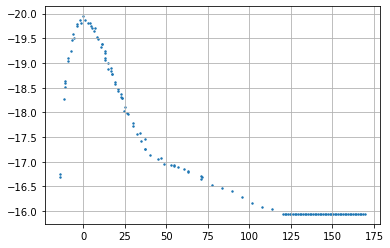

32 II P


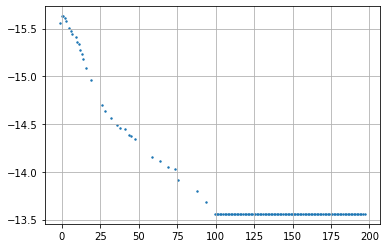

32 II P


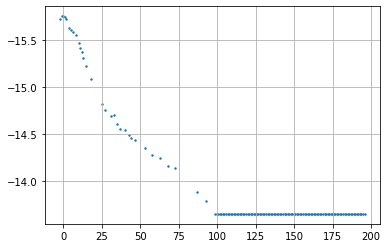

36 Ia


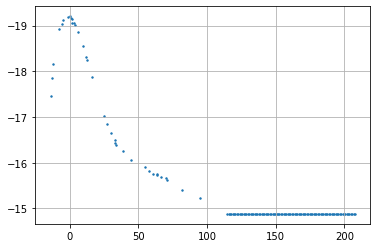

49 Ia


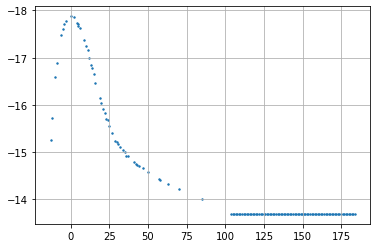

22 Ia


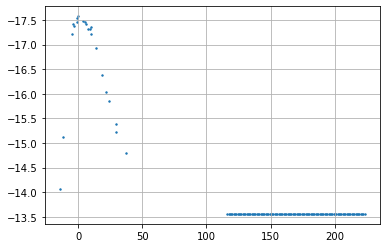

22 Ia


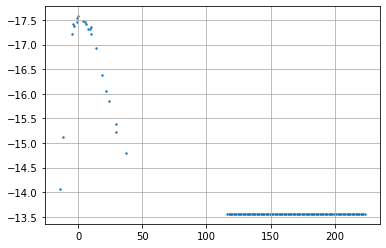

16 Ia


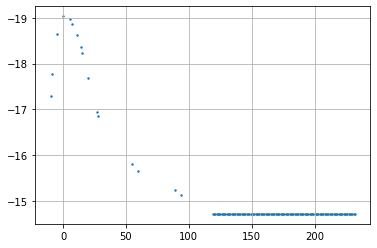

37 Ia


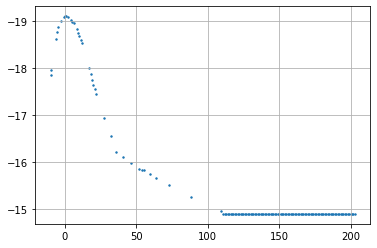

58 Ia


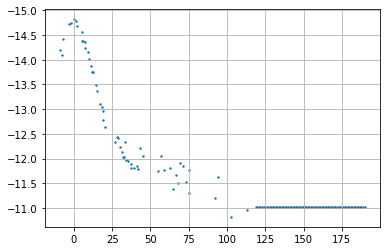

73 Ia


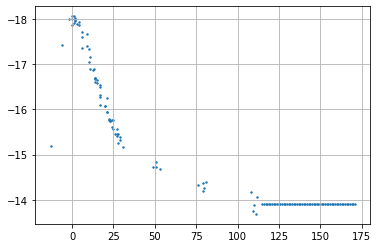

24 Ia


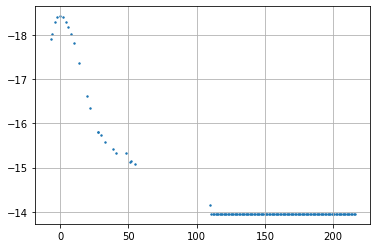

42 Ia


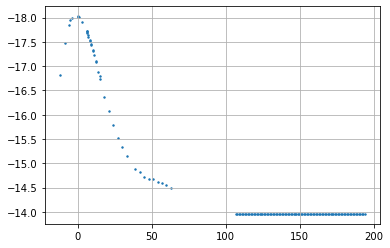

42 Ia


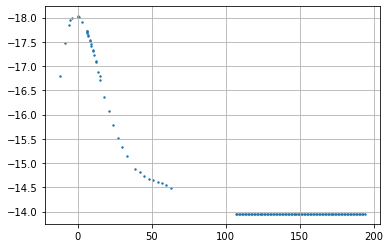

29 Ia


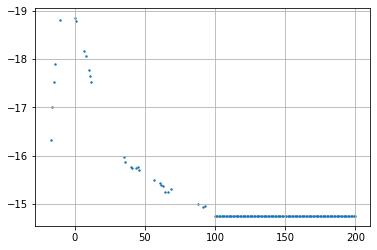

84 II P


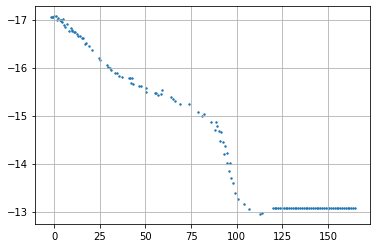

129 Ia


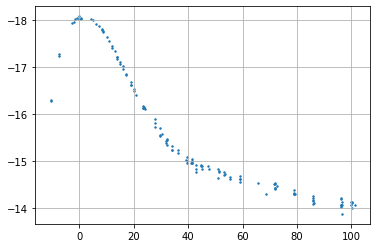

32 Ia


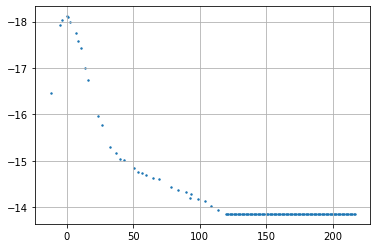

19 II P


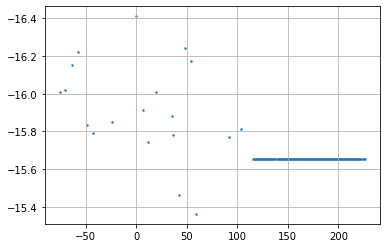

59 Ia


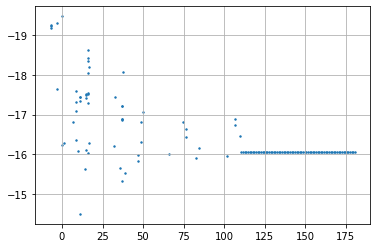

44 Ia Pec


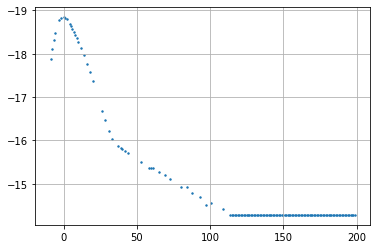

43 Ia Pec


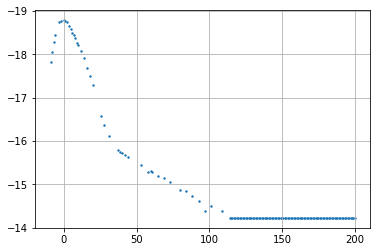

64 Ia Pec


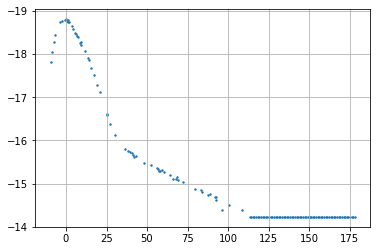

27 Ia


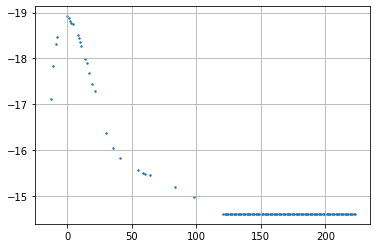

71 II


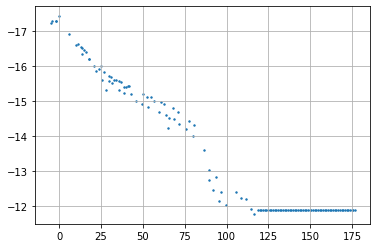

34 II


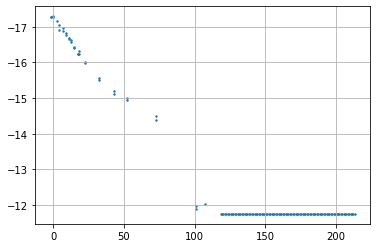

76 II


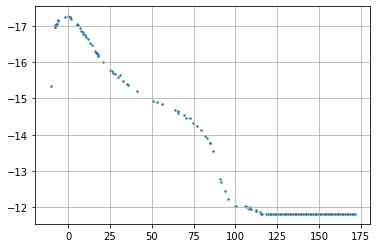

21 II


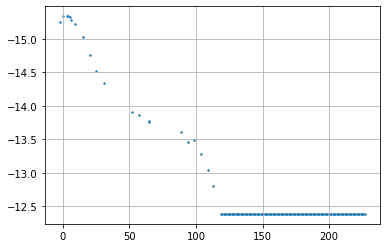

(43, 2, 130)


In [20]:
'''This cell serves as selecting suitable light curves,
and also padding of the suitable light curves therefore they all have the same length (no. of data points),
at the end this cell will return'''

data = [] # Store data to be used in the nueral network
lightcurve_length_max = 0 # Store the maximum light curve length
#lightcurve_length_max = 130
lightcurve_length = [] # Store the length of each light curve to calculate the no. of point to be padded
lightcurve_days = 120 # No. of days after the peak to be truncated to the data

lightcurve_succ = [] # Store the id of the exact lightcurves that are filtered (id of the list Sample_Count)
#Time_tail = []
#Magnitude_Abs_tail = []


# Data selection
for i in range(Sample_Count):
    
    if len(Time[i]) > 15: # Avoid lightcurve with too few data points
        
        #Time_tail.append([])
        #Magnitude_Abs_tail.append([])
        
        slope = 0
        
        for j in range(3): # Maybe try to use polynomial fit and check if minimum exist?
            slope += (Magnitude_Abs[i][j+1] - Magnitude_Abs[i][j]) / (Time[i][j+1] - Time[i][j]) # Calculate the average slope between 1st and 4th data point to select out data with rising peak only
            
        if slope < 0: # Choose lightcurve with a rising peak initially
            
            '''maximum = np.argmin(Magnitude_Abs[i])
            Time_tail[i] = Time[i][maximum:]
            Magnitude_Abs_tail[i] = Magnitude_Abs[i][maximum:]'''
            
            maximum = np.argmin(Magnitude_Abs[i]) # Find the id of the peak
            
            if (Time[i][-1] - Time[i][maximum]) > lightcurve_days: # Select lightcurves longer than 120 days after peak
                
                for j in range(len(Time[i])):
                    if ((Time[i][j] - Time[i][maximum]) > lightcurve_days):
                        
                         
                        
                        lightcurve_length_max = max([j, lightcurve_length_max]) # Obtain the maximum lightcurve length
                        
                        if ((Time[i][j-1] - Time[i][maximum]) < 150) & ((Time[i][j-1] - Time[i][maximum]) > 80) :
                            lightcurve_length.append(j-1) # Store the no. of data point of each lightcurve just before 100 days after peak
                            lightcurve_succ.append(i) # Store the id of sample that is stored in data[[]]
                            break
                        
                        '''if lightcurve_length[-1] < lightcurve_length_max:
                            lightcurve_succ.append(i)
                        else:
                            del lightcurve_length[-1]
                        break'''
                        
                        
print('The maximum lightcurve length is', lightcurve_length_max)
print(lightcurve_succ)
print(lightcurve_length)
print(len(lightcurve_succ), len(lightcurve_length))

# Padding the lightcurve

t = []
m = []
t_temp = []
m_temp = []

for i in range(len(lightcurve_succ)):
    
    t.append([])
    m.append([])
    t_temp.append([])
    m_temp.append([])
    
    for j in range(lightcurve_length_max - lightcurve_length[i]):
        t_temp[i].append(Time[lightcurve_succ[i]][lightcurve_length[i]] - Time[lightcurve_succ[i]][0] + j + 1) # Padding days, +1 day after each datapoint after 100 days, -1
        #t_temp[i].append(Time[lightcurve_succ[i]][np.argmin(Magnitude_Abs[lightcurve_succ[i]])] - Time[lightcurve_succ[i]][0])
        m_temp[i].append(Magnitude_Abs[lightcurve_succ[i]][lightcurve_length[i]]) # Padding magnitude with the magnitude just before 100 days, -1
        #m_temp[i].append(Magnitude_Abs[lightcurve_succ[i]][lightcurve_length[i]] - 0.01*j)
        #m_temp[i].append(0)
        
    t_temp2 = np.array(Time[lightcurve_succ[i]][0:lightcurve_length[i]]) # Physical data points
    t_temp2 = t_temp2[:] - Time[lightcurve_succ[i]][0] # Create a relative days
        
    t[i] = np.hstack((t_temp2, t_temp[i])) 
    m[i] = np.hstack((Magnitude_Abs[lightcurve_succ[i]][0:lightcurve_length[i]], m_temp[i]))
    
    # Shift the days to align the peaks to be at 0 day
    maximum = np.argmin(m[i])
    diff = t[i][maximum] - t[i][0]
    t[i] = t[i] - diff
    
    data.append([t[i], m[i]])


print('No. of data is', len(data))
    
# Print out the padded lightcurve
for i in range(len(data)):
    print(lightcurve_length[i], Type[lightcurve_succ[i]])
    plt.gca().invert_yaxis()
    plt.grid()
    plt.scatter(data[i][0], data[i][1], s=2)
    plt.show()
    
data = np.array(data)
print(data.shape)

In [258]:
# Spliting training set and testing set

split_portion = 0.7
split = int(split_portion*(data.shape[0]))

#Input = [[],[],[]]
Input = [[],[],[],[]]

Type1 = [i.replace('II P Pec', '1') for i in Type]
Type1 = [i.replace('II P', '1') for i in Type1]
Type1 = [i.replace('II', '1') for i in Type1]
Type1 = [i.replace('.2P', '1') for i in Type1]
Type1 = [i.replace('.Ia', '0') for i in Type1]
Type1 = [i.replace('Ia Pec', '0') for i in Type1]
Type1 = [i.replace('Ia', '0') for i in Type1]
Type1 = [float(Type1[lightcurve_succ[i]]) for i in range(len(lightcurve_succ))]
Type1 = np.array(Type1)

for i in range(len(Type1)):
    Input[0].append(data[i])
    if Type1[i] == 0:
        Input[1].append(data[i])
    if Type1[i] == 1:
        Input[2].append(data[i])
        

Input_train = []
Input_test = []
Type_train = []
Type_test = []

for i in range(3):
    Input_train.append([])
    Input_test.append([])
    Type_train.append([])
    Type_test.append([])
    
    Input[i] = np.array(Input[i])
    Input_train[i] = Input[i][:int(split_portion*len(Input[i]))]
    Input_test[i] = Input[i][int(split_portion*len(Input[i])):]
    Input[i] = Input[i].transpose((0, 2, 1))
    Input_train[i] = Input_train[i].transpose((0, 2, 1))
    Input_test[i] = Input_test[i].transpose((0, 2, 1))
    
    Type_train[i] = Type1[:int(split_portion*len(Input[i]))]
    Type_test[i] = Type1[int(split_portion*len(Input[i])):]

print(Input[0].shape) #no. of sample (batch size), timesteps in RNN, no. of features
print(Input_test[0].shape)
print(np.array(Type1).shape)

'''Input[3] = [[[1.2*j, -0.1*j] for j in range(lightcurve_length_max)] for i in range(10)]
Input[3] = np.array(Input[3])

Input_train.append([])
Input_test.append([])
Input_train[3] = Input[3][:split]
Input_test[3] = Input[3][split:]
print(Input[3].shape)

Type_3 = [i.replace('II P Pec', '2') for i in Type]
Type_3 = [i.replace('II P', '2') for i in Type_3]
Type_3 = [i.replace('II', '2') for i in Type_3]
Type_3 = [i.replace('.2P', '2') for i in Type_3]
Type_3 = [i.replace('.Ia', '1') for i in Type_3]
Type_3 = [i.replace('Ia Pec', '1') for i in Type_3]
Type_3 = [i.replace('Ia', '1') for i in Type_3]
Type_3 = [float(Type_3[lightcurve_succ[i]]) for i in range(len(lightcurve_succ))]
for i in range(Input[3].shape[0]):
    Type_3.append(3.0)
Type_3 = np.array(Type_3)

Input[0] = np.vstack((Input[0], Input[3]))
print(Input[0].shape)
np.random.seed(1)
np.random.shuffle(Type_3)
np.random.shuffle(Input[0])
print(Type_3)

Input_train[0] = Input[0][:50]
Input_test[0] = Input[0][50:]'''

(43, 130, 2)
(13, 130, 2)
(43,)


"Input[3] = [[[1.2*j, -0.1*j] for j in range(lightcurve_length_max)] for i in range(10)]\nInput[3] = np.array(Input[3])\n\nInput_train.append([])\nInput_test.append([])\nInput_train[3] = Input[3][:split]\nInput_test[3] = Input[3][split:]\nprint(Input[3].shape)\n\nType_3 = [i.replace('II P Pec', '2') for i in Type]\nType_3 = [i.replace('II P', '2') for i in Type_3]\nType_3 = [i.replace('II', '2') for i in Type_3]\nType_3 = [i.replace('.2P', '2') for i in Type_3]\nType_3 = [i.replace('.Ia', '1') for i in Type_3]\nType_3 = [i.replace('Ia Pec', '1') for i in Type_3]\nType_3 = [i.replace('Ia', '1') for i in Type_3]\nType_3 = [float(Type_3[lightcurve_succ[i]]) for i in range(len(lightcurve_succ))]\nfor i in range(Input[3].shape[0]):\n    Type_3.append(3.0)\nType_3 = np.array(Type_3)\n\nInput[0] = np.vstack((Input[0], Input[3]))\nprint(Input[0].shape)\nnp.random.seed(1)\nnp.random.shuffle(Type_3)\nnp.random.shuffle(Input[0])\nprint(Type_3)\n\nInput_train[0] = Input[0][:50]\nInput_test[0] = In

In [259]:
# Custom loss function weighting the non-padding part

weight = []
for i in range(Input_train[0].shape[0]):
    temp1 = [1 for j in range(lightcurve_length[i])]
    temp2 = [0 for j in range(Input_train[0].shape[1]-lightcurve_length[i])]
    temp = np.hstack((temp1, temp2))
    weight.append(temp)
    weight1 = np.array(weight)
print(weight1[0])
print(weight1.shape)

mask_train = np.array([[[1*weight1[j,i], 1*weight1[j,i]] for i in range(weight1.shape[1])] for j in range(weight1.shape[0])])
print(mask_train.shape)


weight = []
for i in range(Input_test[0].shape[0]):
    temp1 = [1 for j in range(lightcurve_length[i+split])]
    temp2 = [0 for j in range(Input_test[0].shape[1]-lightcurve_length[i+split])]
    temp = np.hstack((temp1, temp2))
    weight.append(temp)
    weight2 = np.array(weight)
print(weight2[0])
print(weight2.shape)

mask_test = np.array([[[1*weight2[j,i], 1*weight2[j,i]] for i in range(weight2.shape[1])] for j in range(weight2.shape[0])])
print(mask_test.shape)


def my_loss_fn(y_true, y_pred, mask):
    
    y_pred_masked = tf.math.multiply(y_pred, mask)
    mse = tf.keras.losses.mean_squared_error(y_true = y_true, y_pred = y_pred_masked)
    return mse

print(my_loss_fn(Input_train[0], 0.8*Input_train[0], mask_train))

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(30, 130)
(30, 130, 2)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(13, 130)
(13, 130, 2)
tf.Tensor(
[[8.69834596e+00 8.05410631e+00 7.82884931e+00 ... 1.94678661e+04
  1.96652061e+04 1.98635461e+04]
 [5.83676843e+00 4.95307722e+00 4.81916729e+00 ... 1.94278181e+04
  1.96250781e+04 1.98233381e+04]
 [8.68573393e+00 8.38960026e+00 8.16572792e+00 ... 7.97326271e+03
  8.09931961e+03 8.22637651e+03]
 ...
 [8.53410942e+00 7.73976646e+00 7.09490640e+00 ... 1.84871790e+04
  1.86794590e+04 1.88727390e+04]
 [8.53074858

Model: "model_1980"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_81 (InputLayer)           [(None, 130, 2)]     0                                            
__________________________________________________________________________________________________
bidirectional_120 (Bidirectiona (None, 130, 360)     198720      input_81[0][0]                   
__________________________________________________________________________________________________
bidirectional_121 (Bidirectiona (None, 32)           36288       bidirectional_120[0][0]          
__________________________________________________________________________________________________
repeat_vector_40 (RepeatVector) (None, 130, 32)      0           bidirectional_121[0][0]          
_________________________________________________________________________________________

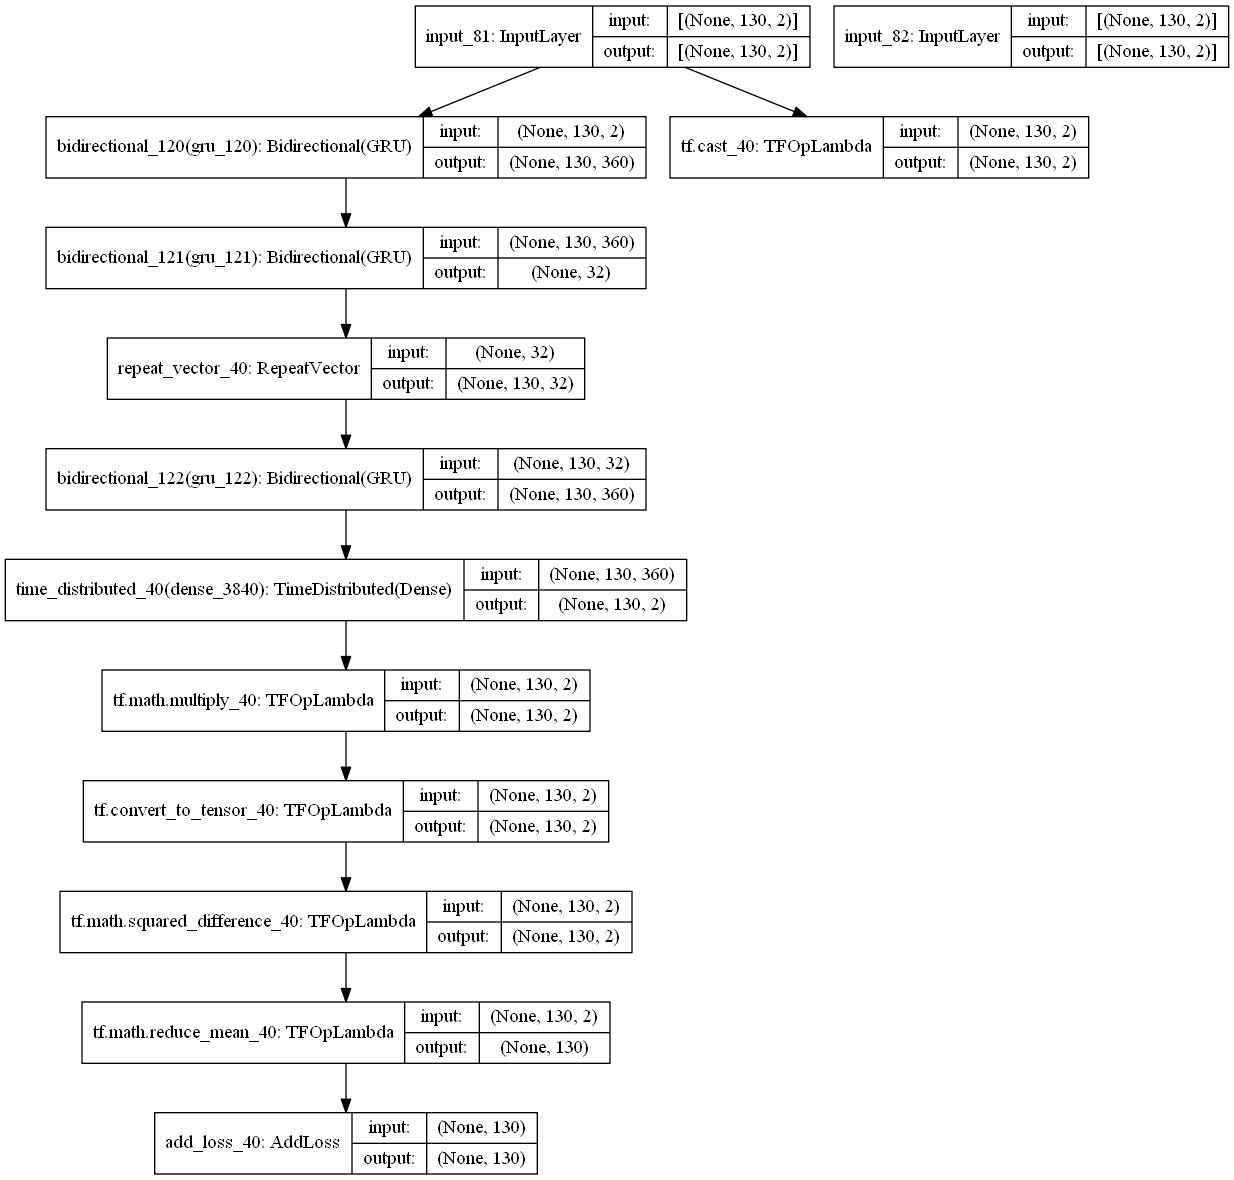

In [328]:
# Autoencoder

input_seq = keras.Input(shape=(lightcurve_length_max, 2))
input_mask = keras.Input(shape=(lightcurve_length_max, 2))

x = Bidirectional(GRU(180, activation='tanh', return_sequences=True))(input_seq)
encoded = Bidirectional(GRU(16, activation='tanh', return_sequences=False))(x)

x = RepeatVector(lightcurve_length_max)(encoded)
x = Bidirectional(GRU(180, activation='tanh', return_sequences=True))(x)
decoded = TimeDistributed(Dense(2))(x)

autoencoder = keras.Model([input_seq, input_mask], decoded)
autoencoder.add_loss(my_loss_fn(input_seq, decoded, input_mask))
encoder = keras.Model(input_seq, encoded)

opt = Adam(learning_rate=0.001)

autoencoder.compile(optimizer=opt, loss=None)
autoencoder.summary()
plot_model(autoencoder, show_shapes=True)

In [329]:
callbacks = EarlyStopping(monitor='loss', min_delta=1e-3, patience=30, restore_best_weights=True)
history = autoencoder.fit(x=[Input_train[0], mask_train], y=None, validation_split = 0.1, epochs=2000, verbose=1)

Epoch 1/2000
1/1 [==============================] - 7s 7s/step - loss: 8325.0518 - val_loss: 8512.9463
Epoch 2/2000
1/1 [==============================] - 0s 83ms/step - loss: 8307.3799 - val_loss: 8504.6885
Epoch 3/2000
1/1 [==============================] - 0s 79ms/step - loss: 8292.2041 - val_loss: 8496.5303
Epoch 4/2000
1/1 [==============================] - 0s 80ms/step - loss: 8276.5010 - val_loss: 8487.8545
Epoch 5/2000
1/1 [==============================] - 0s 74ms/step - loss: 8259.4004 - val_loss: 8478.6650
Epoch 6/2000
1/1 [==============================] - 0s 74ms/step - loss: 8241.1494 - val_loss: 8469.1875
Epoch 7/2000
1/1 [==============================] - 0s 70ms/step - loss: 8222.1514 - val_loss: 8459.6914
Epoch 8/2000
1/1 [==============================] - 0s 76ms/step - loss: 8202.7725 - val_loss: 8450.5273
Epoch 9/2000
1/1 [==============================] - 0s 74ms/step - loss: 8183.5679 - val_loss: 8442.1182
Epoch 10/2000
1/1 [==============================] - 0s 7

Epoch 71/2000
1/1 [==============================] - 0s 67ms/step - loss: 7999.0815 - val_loss: 8383.7197
Epoch 72/2000
1/1 [==============================] - 0s 65ms/step - loss: 7997.5234 - val_loss: 8385.8193
Epoch 73/2000
1/1 [==============================] - 0s 64ms/step - loss: 7996.0957 - val_loss: 8380.5684
Epoch 74/2000
1/1 [==============================] - 0s 67ms/step - loss: 7994.7778 - val_loss: 8384.8770
Epoch 75/2000
1/1 [==============================] - 0s 73ms/step - loss: 7992.9834 - val_loss: 8383.0625
Epoch 76/2000
1/1 [==============================] - 0s 73ms/step - loss: 7991.5977 - val_loss: 8380.4941
Epoch 77/2000
1/1 [==============================] - 0s 68ms/step - loss: 7990.3540 - val_loss: 8383.7305
Epoch 78/2000
1/1 [==============================] - 0s 68ms/step - loss: 7989.2363 - val_loss: 8376.5049
Epoch 79/2000
1/1 [==============================] - 0s 74ms/step - loss: 7988.6948 - val_loss: 8381.6895
Epoch 80/2000
1/1 [===========================

Epoch 148/2000
1/1 [==============================] - 0s 78ms/step - loss: 7930.0210 - val_loss: 8354.7393
Epoch 149/2000
1/1 [==============================] - 0s 77ms/step - loss: 7929.5356 - val_loss: 8355.0605
Epoch 150/2000
1/1 [==============================] - 0s 78ms/step - loss: 7929.4312 - val_loss: 8354.6533
Epoch 151/2000
1/1 [==============================] - 0s 79ms/step - loss: 7928.5405 - val_loss: 8354.1494
Epoch 152/2000
1/1 [==============================] - 0s 77ms/step - loss: 7927.8213 - val_loss: 8353.5918
Epoch 153/2000
1/1 [==============================] - 0s 75ms/step - loss: 7926.6675 - val_loss: 8352.9561
Epoch 154/2000
1/1 [==============================] - 0s 70ms/step - loss: 7925.8730 - val_loss: 8352.5967
Epoch 155/2000
1/1 [==============================] - 0s 74ms/step - loss: 7925.2856 - val_loss: 8352.9375
Epoch 156/2000
1/1 [==============================] - 0s 71ms/step - loss: 7924.8149 - val_loss: 8352.6465
Epoch 157/2000
1/1 [=================

1/1 [==============================] - 0s 72ms/step - loss: 7900.3135 - val_loss: 8339.9805
Epoch 225/2000
1/1 [==============================] - 0s 70ms/step - loss: 7896.1060 - val_loss: 8351.5645
Epoch 226/2000
1/1 [==============================] - 0s 70ms/step - loss: 7898.6963 - val_loss: 8340.8057
Epoch 227/2000
1/1 [==============================] - 0s 70ms/step - loss: 7889.1646 - val_loss: 8340.6572
Epoch 228/2000
1/1 [==============================] - 0s 69ms/step - loss: 7894.6768 - val_loss: 8337.6875
Epoch 229/2000
1/1 [==============================] - 0s 73ms/step - loss: 7889.2661 - val_loss: 8345.1035
Epoch 230/2000
1/1 [==============================] - 0s 71ms/step - loss: 7894.7441 - val_loss: 8337.8223
Epoch 231/2000
1/1 [==============================] - 0s 76ms/step - loss: 7887.6802 - val_loss: 8337.7500
Epoch 232/2000
1/1 [==============================] - 0s 72ms/step - loss: 7891.3164 - val_loss: 8337.5361
Epoch 233/2000
1/1 [==============================] 

1/1 [==============================] - 0s 73ms/step - loss: 7871.7109 - val_loss: 8333.8057
Epoch 301/2000
1/1 [==============================] - 0s 71ms/step - loss: 7871.5327 - val_loss: 8333.6943
Epoch 302/2000
1/1 [==============================] - 0s 74ms/step - loss: 7871.3584 - val_loss: 8333.7451
Epoch 303/2000
1/1 [==============================] - 0s 67ms/step - loss: 7871.1816 - val_loss: 8333.6035
Epoch 304/2000
1/1 [==============================] - 0s 73ms/step - loss: 7871.0088 - val_loss: 8333.6426
Epoch 305/2000
1/1 [==============================] - 0s 69ms/step - loss: 7870.8320 - val_loss: 8333.4854
Epoch 306/2000
1/1 [==============================] - 0s 72ms/step - loss: 7870.6587 - val_loss: 8333.5898
Epoch 307/2000
1/1 [==============================] - 0s 72ms/step - loss: 7870.4854 - val_loss: 8333.4111
Epoch 308/2000
1/1 [==============================] - 0s 72ms/step - loss: 7870.3223 - val_loss: 8333.6113
Epoch 309/2000
1/1 [==============================] 

1/1 [==============================] - 0s 65ms/step - loss: 7861.7056 - val_loss: 8332.3311
Epoch 377/2000
1/1 [==============================] - 0s 66ms/step - loss: 7861.7437 - val_loss: 8332.5605
Epoch 378/2000
1/1 [==============================] - 0s 65ms/step - loss: 7862.4121 - val_loss: 8335.0469
Epoch 379/2000
1/1 [==============================] - 0s 65ms/step - loss: 7865.9365 - val_loss: 8347.6436
Epoch 380/2000
1/1 [==============================] - 0s 69ms/step - loss: 7876.8936 - val_loss: 8339.7881
Epoch 381/2000
1/1 [==============================] - 0s 72ms/step - loss: 7875.0190 - val_loss: 8331.2734
Epoch 382/2000
1/1 [==============================] - 0s 69ms/step - loss: 7863.6499 - val_loss: 8331.9824
Epoch 383/2000
1/1 [==============================] - 0s 71ms/step - loss: 7865.9941 - val_loss: 8337.1787
Epoch 384/2000
1/1 [==============================] - 0s 71ms/step - loss: 7868.0068 - val_loss: 8332.4072
Epoch 385/2000
1/1 [==============================] 

1/1 [==============================] - 0s 72ms/step - loss: 7857.6348 - val_loss: 8333.6807
Epoch 453/2000
1/1 [==============================] - 0s 70ms/step - loss: 7858.2451 - val_loss: 8332.1934
Epoch 454/2000
1/1 [==============================] - 0s 66ms/step - loss: 7858.4170 - val_loss: 8333.6650
Epoch 455/2000
1/1 [==============================] - 0s 70ms/step - loss: 7858.3516 - val_loss: 8331.8965
Epoch 456/2000
1/1 [==============================] - 0s 70ms/step - loss: 7857.4360 - val_loss: 8332.1670
Epoch 457/2000
1/1 [==============================] - 0s 70ms/step - loss: 7856.5835 - val_loss: 8331.8320
Epoch 458/2000
1/1 [==============================] - 0s 70ms/step - loss: 7856.1479 - val_loss: 8331.9688
Epoch 459/2000
1/1 [==============================] - 0s 72ms/step - loss: 7856.3115 - val_loss: 8332.6182
Epoch 460/2000
1/1 [==============================] - 0s 66ms/step - loss: 7856.7871 - val_loss: 8332.2549
Epoch 461/2000
1/1 [==============================] 

1/1 [==============================] - 0s 71ms/step - loss: 7853.6992 - val_loss: 8330.3252
Epoch 529/2000
1/1 [==============================] - 0s 70ms/step - loss: 7853.4399 - val_loss: 8330.6660
Epoch 530/2000
1/1 [==============================] - 0s 71ms/step - loss: 7853.3145 - val_loss: 8330.9072
Epoch 531/2000
1/1 [==============================] - 0s 70ms/step - loss: 7853.3237 - val_loss: 8330.1172
Epoch 532/2000
1/1 [==============================] - 0s 68ms/step - loss: 7853.4331 - val_loss: 8331.3271
Epoch 533/2000
1/1 [==============================] - 0s 70ms/step - loss: 7853.4585 - val_loss: 8330.0186
Epoch 534/2000
1/1 [==============================] - 0s 71ms/step - loss: 7853.4189 - val_loss: 8331.2295
Epoch 535/2000
1/1 [==============================] - 0s 71ms/step - loss: 7853.3403 - val_loss: 8330.0928
Epoch 536/2000
1/1 [==============================] - 0s 75ms/step - loss: 7853.2256 - val_loss: 8330.9648
Epoch 537/2000
1/1 [==============================] 

1/1 [==============================] - 0s 67ms/step - loss: 7851.4268 - val_loss: 8333.8652
Epoch 605/2000
1/1 [==============================] - 0s 71ms/step - loss: 7852.4854 - val_loss: 8329.4355
Epoch 606/2000
1/1 [==============================] - 0s 69ms/step - loss: 7854.0894 - val_loss: 8334.7588
Epoch 607/2000
1/1 [==============================] - 0s 71ms/step - loss: 7853.7788 - val_loss: 8328.9033
Epoch 608/2000
1/1 [==============================] - 0s 70ms/step - loss: 7852.4609 - val_loss: 8329.6016
Epoch 609/2000
1/1 [==============================] - 0s 73ms/step - loss: 7851.3335 - val_loss: 8332.9473
Epoch 610/2000
1/1 [==============================] - 0s 69ms/step - loss: 7852.1582 - val_loss: 8328.3916
Epoch 611/2000
1/1 [==============================] - 0s 71ms/step - loss: 7853.8428 - val_loss: 8335.8223
Epoch 612/2000
1/1 [==============================] - 0s 68ms/step - loss: 7853.5850 - val_loss: 8328.5107
Epoch 613/2000
1/1 [==============================] 

1/1 [==============================] - 0s 70ms/step - loss: 7851.0098 - val_loss: 8336.1914
Epoch 681/2000
1/1 [==============================] - 0s 70ms/step - loss: 7851.1870 - val_loss: 8327.8018
Epoch 682/2000
1/1 [==============================] - 0s 71ms/step - loss: 7851.1572 - val_loss: 8334.0879
Epoch 683/2000
1/1 [==============================] - 0s 67ms/step - loss: 7850.4595 - val_loss: 8330.2051
Epoch 684/2000
1/1 [==============================] - 0s 67ms/step - loss: 7850.0273 - val_loss: 8330.9600
Epoch 685/2000
1/1 [==============================] - 0s 66ms/step - loss: 7849.9546 - val_loss: 8333.8984
Epoch 686/2000
1/1 [==============================] - 0s 66ms/step - loss: 7850.1763 - val_loss: 8328.7119
Epoch 687/2000
1/1 [==============================] - 0s 64ms/step - loss: 7850.6152 - val_loss: 8336.9688
Epoch 688/2000
1/1 [==============================] - 0s 66ms/step - loss: 7850.9448 - val_loss: 8328.0137
Epoch 689/2000
1/1 [==============================] 

1/1 [==============================] - 0s 68ms/step - loss: 7850.2300 - val_loss: 8333.3525
Epoch 757/2000
1/1 [==============================] - 0s 70ms/step - loss: 7850.2329 - val_loss: 8327.9600
Epoch 758/2000
1/1 [==============================] - 0s 68ms/step - loss: 7849.6284 - val_loss: 8330.5889
Epoch 759/2000
1/1 [==============================] - 0s 69ms/step - loss: 7849.2822 - val_loss: 8333.5703
Epoch 760/2000
1/1 [==============================] - 0s 70ms/step - loss: 7849.5669 - val_loss: 8327.4854
Epoch 761/2000
1/1 [==============================] - 0s 69ms/step - loss: 7850.0625 - val_loss: 8332.9082
Epoch 762/2000
1/1 [==============================] - 0s 71ms/step - loss: 7849.6958 - val_loss: 8329.1016
Epoch 763/2000
1/1 [==============================] - 0s 73ms/step - loss: 7849.2446 - val_loss: 8328.9639
Epoch 764/2000
1/1 [==============================] - 0s 70ms/step - loss: 7849.2773 - val_loss: 8334.3320
Epoch 765/2000
1/1 [==============================] 

1/1 [==============================] - 0s 69ms/step - loss: 7848.6475 - val_loss: 8332.2539
Epoch 833/2000
1/1 [==============================] - 0s 68ms/step - loss: 7848.6392 - val_loss: 8329.7734
Epoch 834/2000
1/1 [==============================] - 0s 70ms/step - loss: 7848.7622 - val_loss: 8334.8174
Epoch 835/2000
1/1 [==============================] - 0s 71ms/step - loss: 7848.9512 - val_loss: 8328.3438
Epoch 836/2000
1/1 [==============================] - 0s 69ms/step - loss: 7849.2266 - val_loss: 8336.4502
Epoch 837/2000
1/1 [==============================] - 0s 76ms/step - loss: 7849.2832 - val_loss: 8327.8682
Epoch 838/2000
1/1 [==============================] - 0s 68ms/step - loss: 7849.4844 - val_loss: 8336.2695
Epoch 839/2000
1/1 [==============================] - 0s 70ms/step - loss: 7849.3452 - val_loss: 8327.6973
Epoch 840/2000
1/1 [==============================] - 0s 67ms/step - loss: 7849.3198 - val_loss: 8333.8359
Epoch 841/2000
1/1 [==============================] 

1/1 [==============================] - 0s 69ms/step - loss: 7849.2124 - val_loss: 8326.5752
Epoch 909/2000
1/1 [==============================] - 0s 67ms/step - loss: 7849.6362 - val_loss: 8334.9473
Epoch 910/2000
1/1 [==============================] - 0s 68ms/step - loss: 7849.0654 - val_loss: 8327.4688
Epoch 911/2000
1/1 [==============================] - 0s 66ms/step - loss: 7848.7314 - val_loss: 8331.9648
Epoch 912/2000
1/1 [==============================] - 0s 66ms/step - loss: 7848.3491 - val_loss: 8329.8555
Epoch 913/2000
1/1 [==============================] - 0s 66ms/step - loss: 7848.2041 - val_loss: 8328.8535
Epoch 914/2000
1/1 [==============================] - 0s 68ms/step - loss: 7848.2598 - val_loss: 8332.3203
Epoch 915/2000
1/1 [==============================] - 0s 69ms/step - loss: 7848.4414 - val_loss: 8327.3232
Epoch 916/2000
1/1 [==============================] - 0s 68ms/step - loss: 7848.7358 - val_loss: 8334.3916
Epoch 917/2000
1/1 [==============================] 

1/1 [==============================] - 0s 71ms/step - loss: 7848.3730 - val_loss: 8333.0918
Epoch 985/2000
1/1 [==============================] - 0s 72ms/step - loss: 7848.0879 - val_loss: 8329.3906
Epoch 986/2000
1/1 [==============================] - 0s 75ms/step - loss: 7847.9082 - val_loss: 8331.1855
Epoch 987/2000
1/1 [==============================] - 0s 68ms/step - loss: 7847.8325 - val_loss: 8332.3926
Epoch 988/2000
1/1 [==============================] - 0s 71ms/step - loss: 7847.8569 - val_loss: 8329.9805
Epoch 989/2000
1/1 [==============================] - 0s 69ms/step - loss: 7847.9424 - val_loss: 8334.1074
Epoch 990/2000
1/1 [==============================] - 0s 69ms/step - loss: 7848.0688 - val_loss: 8328.5527
Epoch 991/2000
1/1 [==============================] - 0s 69ms/step - loss: 7848.2393 - val_loss: 8336.0215
Epoch 992/2000
1/1 [==============================] - 0s 72ms/step - loss: 7848.4409 - val_loss: 8327.4932
Epoch 993/2000
1/1 [==============================] 

1/1 [==============================] - 0s 70ms/step - loss: 7848.0928 - val_loss: 8329.5918
Epoch 1061/2000
1/1 [==============================] - 0s 69ms/step - loss: 7847.9683 - val_loss: 8335.2939
Epoch 1062/2000
1/1 [==============================] - 0s 69ms/step - loss: 7847.7778 - val_loss: 8330.9473
Epoch 1063/2000
1/1 [==============================] - 0s 71ms/step - loss: 7847.6206 - val_loss: 8333.8223
Epoch 1064/2000
1/1 [==============================] - 0s 70ms/step - loss: 7847.5542 - val_loss: 8332.3262
Epoch 1065/2000
1/1 [==============================] - 0s 68ms/step - loss: 7847.5049 - val_loss: 8332.5566
Epoch 1066/2000
1/1 [==============================] - 0s 76ms/step - loss: 7847.4688 - val_loss: 8333.2617
Epoch 1067/2000
1/1 [==============================] - 0s 72ms/step - loss: 7847.5078 - val_loss: 8331.2920
Epoch 1068/2000
1/1 [==============================] - 0s 68ms/step - loss: 7847.5703 - val_loss: 8334.8662
Epoch 1069/2000
1/1 [=======================

1/1 [==============================] - 0s 67ms/step - loss: 7847.8164 - val_loss: 8339.5801
Epoch 1137/2000
1/1 [==============================] - 0s 65ms/step - loss: 7848.0181 - val_loss: 8329.4502
Epoch 1138/2000
1/1 [==============================] - 0s 65ms/step - loss: 7848.3818 - val_loss: 8340.1113
Epoch 1139/2000
1/1 [==============================] - 0s 66ms/step - loss: 7848.2256 - val_loss: 8329.9746
Epoch 1140/2000
1/1 [==============================] - 0s 68ms/step - loss: 7848.0786 - val_loss: 8338.1133
Epoch 1141/2000
1/1 [==============================] - 0s 69ms/step - loss: 7847.6494 - val_loss: 8332.6631
Epoch 1142/2000
1/1 [==============================] - 0s 72ms/step - loss: 7847.3657 - val_loss: 8334.8145
Epoch 1143/2000
1/1 [==============================] - 0s 70ms/step - loss: 7847.2256 - val_loss: 8335.4355
Epoch 1144/2000
1/1 [==============================] - 0s 74ms/step - loss: 7847.2563 - val_loss: 8332.0332
Epoch 1145/2000
1/1 [=======================

1/1 [==============================] - 0s 67ms/step - loss: 7847.4058 - val_loss: 8332.5664
Epoch 1213/2000
1/1 [==============================] - 0s 73ms/step - loss: 7847.7163 - val_loss: 8342.8887
Epoch 1214/2000
1/1 [==============================] - 0s 68ms/step - loss: 7847.8882 - val_loss: 8331.2422
Epoch 1215/2000
1/1 [==============================] - 0s 70ms/step - loss: 7848.3862 - val_loss: 8344.1250
Epoch 1216/2000
1/1 [==============================] - 0s 70ms/step - loss: 7848.2402 - val_loss: 8331.0332
Epoch 1217/2000
1/1 [==============================] - 0s 67ms/step - loss: 7848.3325 - val_loss: 8341.7090
Epoch 1218/2000
1/1 [==============================] - 0s 70ms/step - loss: 7847.7651 - val_loss: 8334.0605
Epoch 1219/2000
1/1 [==============================] - 0s 71ms/step - loss: 7847.2744 - val_loss: 8337.3984
Epoch 1220/2000
1/1 [==============================] - 0s 65ms/step - loss: 7847.0229 - val_loss: 8337.5293
Epoch 1221/2000
1/1 [=======================

1/1 [==============================] - 0s 69ms/step - loss: 7848.3853 - val_loss: 8330.7148
Epoch 1289/2000
1/1 [==============================] - 0s 69ms/step - loss: 7848.4819 - val_loss: 8341.2705
Epoch 1290/2000
1/1 [==============================] - 0s 69ms/step - loss: 7847.5933 - val_loss: 8337.3613
Epoch 1291/2000
1/1 [==============================] - 0s 75ms/step - loss: 7846.9707 - val_loss: 8337.4150
Epoch 1292/2000
1/1 [==============================] - 0s 69ms/step - loss: 7847.1719 - val_loss: 8341.7969
Epoch 1293/2000
1/1 [==============================] - 0s 72ms/step - loss: 7847.5293 - val_loss: 8331.6230
Epoch 1294/2000
1/1 [==============================] - 0s 70ms/step - loss: 7848.0513 - val_loss: 8343.2939
Epoch 1295/2000
1/1 [==============================] - 0s 75ms/step - loss: 7848.8560 - val_loss: 8329.9189
Epoch 1296/2000
1/1 [==============================] - 0s 69ms/step - loss: 7848.3979 - val_loss: 8337.8857
Epoch 1297/2000
1/1 [=======================

1/1 [==============================] - 0s 65ms/step - loss: 7846.7188 - val_loss: 8336.0625
Epoch 1365/2000
1/1 [==============================] - 0s 68ms/step - loss: 7846.7168 - val_loss: 8338.0459
Epoch 1366/2000
1/1 [==============================] - 0s 73ms/step - loss: 7846.7129 - val_loss: 8336.1562
Epoch 1367/2000
1/1 [==============================] - 0s 69ms/step - loss: 7846.7090 - val_loss: 8338.0723
Epoch 1368/2000
1/1 [==============================] - 0s 70ms/step - loss: 7846.6982 - val_loss: 8336.6982
Epoch 1369/2000
1/1 [==============================] - 0s 69ms/step - loss: 7846.6885 - val_loss: 8338.4238
Epoch 1370/2000
1/1 [==============================] - 0s 68ms/step - loss: 7846.6919 - val_loss: 8336.9297
Epoch 1371/2000
1/1 [==============================] - 0s 68ms/step - loss: 7846.7173 - val_loss: 8337.8828
Epoch 1372/2000
1/1 [==============================] - 0s 78ms/step - loss: 7846.7964 - val_loss: 8339.7129
Epoch 1373/2000
1/1 [=======================

1/1 [==============================] - 0s 68ms/step - loss: 7847.3433 - val_loss: 8332.7646
Epoch 1441/2000
1/1 [==============================] - 0s 69ms/step - loss: 7847.5298 - val_loss: 8342.5381
Epoch 1442/2000
1/1 [==============================] - 0s 74ms/step - loss: 7847.2114 - val_loss: 8334.4238
Epoch 1443/2000
1/1 [==============================] - 0s 70ms/step - loss: 7846.8989 - val_loss: 8339.1621
Epoch 1444/2000
1/1 [==============================] - 0s 71ms/step - loss: 7846.6450 - val_loss: 8338.0586
Epoch 1445/2000
1/1 [==============================] - 0s 68ms/step - loss: 7846.5664 - val_loss: 8335.9521
Epoch 1446/2000
1/1 [==============================] - 0s 66ms/step - loss: 7846.6665 - val_loss: 8341.0010
Epoch 1447/2000
1/1 [==============================] - 0s 65ms/step - loss: 7846.8047 - val_loss: 8334.9707
Epoch 1448/2000
1/1 [==============================] - 0s 65ms/step - loss: 7846.9443 - val_loss: 8342.3926
Epoch 1449/2000
1/1 [=======================

1/1 [==============================] - 0s 69ms/step - loss: 7847.0229 - val_loss: 8336.4043
Epoch 1517/2000
1/1 [==============================] - 0s 70ms/step - loss: 7846.7998 - val_loss: 8339.9717
Epoch 1518/2000
1/1 [==============================] - 0s 71ms/step - loss: 7846.6279 - val_loss: 8335.7266
Epoch 1519/2000
1/1 [==============================] - 0s 70ms/step - loss: 7846.5259 - val_loss: 8337.0645
Epoch 1520/2000
1/1 [==============================] - 0s 73ms/step - loss: 7846.4937 - val_loss: 8338.2480
Epoch 1521/2000
1/1 [==============================] - 0s 68ms/step - loss: 7846.4893 - val_loss: 8336.7822
Epoch 1522/2000
1/1 [==============================] - 0s 71ms/step - loss: 7846.5298 - val_loss: 8340.7598
Epoch 1523/2000
1/1 [==============================] - 0s 68ms/step - loss: 7846.6138 - val_loss: 8336.5791
Epoch 1524/2000
1/1 [==============================] - 0s 69ms/step - loss: 7846.6533 - val_loss: 8342.0195
Epoch 1525/2000
1/1 [=======================

1/1 [==============================] - 0s 69ms/step - loss: 7846.3433 - val_loss: 8340.5664
Epoch 1593/2000
1/1 [==============================] - 0s 69ms/step - loss: 7846.4507 - val_loss: 8335.5508
Epoch 1594/2000
1/1 [==============================] - 0s 69ms/step - loss: 7846.6597 - val_loss: 8342.7061
Epoch 1595/2000
1/1 [==============================] - 0s 70ms/step - loss: 7846.8604 - val_loss: 8333.6182
Epoch 1596/2000
1/1 [==============================] - 0s 75ms/step - loss: 7847.1182 - val_loss: 8343.0166
Epoch 1597/2000
1/1 [==============================] - 0s 72ms/step - loss: 7847.0728 - val_loss: 8334.0586
Epoch 1598/2000
1/1 [==============================] - 0s 70ms/step - loss: 7847.0293 - val_loss: 8342.1982
Epoch 1599/2000
1/1 [==============================] - 0s 68ms/step - loss: 7846.7744 - val_loss: 8335.5293
Epoch 1600/2000
1/1 [==============================] - 0s 69ms/step - loss: 7846.5669 - val_loss: 8339.7627
Epoch 1601/2000
1/1 [=======================

1/1 [==============================] - 0s 70ms/step - loss: 7846.9341 - val_loss: 8342.3555
Epoch 1669/2000
1/1 [==============================] - 0s 69ms/step - loss: 7846.8901 - val_loss: 8334.1934
Epoch 1670/2000
1/1 [==============================] - 0s 68ms/step - loss: 7846.7773 - val_loss: 8341.0664
Epoch 1671/2000
1/1 [==============================] - 0s 68ms/step - loss: 7846.5586 - val_loss: 8336.0654
Epoch 1672/2000
1/1 [==============================] - 0s 64ms/step - loss: 7846.3579 - val_loss: 8339.0498
Epoch 1673/2000
1/1 [==============================] - 0s 64ms/step - loss: 7846.2393 - val_loss: 8338.1113
Epoch 1674/2000
1/1 [==============================] - 0s 65ms/step - loss: 7846.2085 - val_loss: 8336.7471
Epoch 1675/2000
1/1 [==============================] - 0s 65ms/step - loss: 7846.2383 - val_loss: 8339.5938
Epoch 1676/2000
1/1 [==============================] - 0s 68ms/step - loss: 7846.3237 - val_loss: 8335.3721
Epoch 1677/2000
1/1 [=======================

1/1 [==============================] - 0s 71ms/step - loss: 7846.1460 - val_loss: 8336.5400
Epoch 1745/2000
1/1 [==============================] - 0s 75ms/step - loss: 7846.2344 - val_loss: 8341.1328
Epoch 1746/2000
1/1 [==============================] - 0s 69ms/step - loss: 7846.3315 - val_loss: 8335.7471
Epoch 1747/2000
1/1 [==============================] - 0s 74ms/step - loss: 7846.5176 - val_loss: 8343.1289
Epoch 1748/2000
1/1 [==============================] - 0s 70ms/step - loss: 7846.7104 - val_loss: 8334.0859
Epoch 1749/2000
1/1 [==============================] - 0s 74ms/step - loss: 7846.9971 - val_loss: 8343.3066
Epoch 1750/2000
1/1 [==============================] - 0s 69ms/step - loss: 7846.8774 - val_loss: 8334.2461
Epoch 1751/2000
1/1 [==============================] - 0s 70ms/step - loss: 7846.8052 - val_loss: 8341.3672
Epoch 1752/2000
1/1 [==============================] - 0s 70ms/step - loss: 7846.5640 - val_loss: 8335.8555
Epoch 1753/2000
1/1 [=======================

1/1 [==============================] - 0s 69ms/step - loss: 7846.5708 - val_loss: 8334.9521
Epoch 1821/2000
1/1 [==============================] - 0s 68ms/step - loss: 7846.8535 - val_loss: 8342.9727
Epoch 1822/2000
1/1 [==============================] - 0s 70ms/step - loss: 7846.7856 - val_loss: 8333.7646
Epoch 1823/2000
1/1 [==============================] - 0s 70ms/step - loss: 7846.8643 - val_loss: 8341.0156
Epoch 1824/2000
1/1 [==============================] - 0s 72ms/step - loss: 7846.6133 - val_loss: 8335.5703
Epoch 1825/2000
1/1 [==============================] - 0s 70ms/step - loss: 7846.3052 - val_loss: 8337.4766
Epoch 1826/2000
1/1 [==============================] - 0s 72ms/step - loss: 7846.1289 - val_loss: 8338.3164
Epoch 1827/2000
1/1 [==============================] - 0s 70ms/step - loss: 7846.1133 - val_loss: 8335.4375
Epoch 1828/2000
1/1 [==============================] - 0s 74ms/step - loss: 7846.3032 - val_loss: 8341.5225
Epoch 1829/2000
1/1 [=======================

1/1 [==============================] - 0s 68ms/step - loss: 7845.9634 - val_loss: 8339.0127
Epoch 1897/2000
1/1 [==============================] - 0s 67ms/step - loss: 7846.0127 - val_loss: 8336.1055
Epoch 1898/2000
1/1 [==============================] - 0s 65ms/step - loss: 7846.1123 - val_loss: 8340.8984
Epoch 1899/2000
1/1 [==============================] - 0s 64ms/step - loss: 7846.2388 - val_loss: 8335.2021
Epoch 1900/2000
1/1 [==============================] - 0s 64ms/step - loss: 7846.3853 - val_loss: 8342.2715
Epoch 1901/2000
1/1 [==============================] - 0s 65ms/step - loss: 7846.4170 - val_loss: 8335.2715
Epoch 1902/2000
1/1 [==============================] - 0s 71ms/step - loss: 7846.5527 - val_loss: 8342.1982
Epoch 1903/2000
1/1 [==============================] - 0s 69ms/step - loss: 7846.5459 - val_loss: 8334.1641
Epoch 1904/2000
1/1 [==============================] - 0s 69ms/step - loss: 7846.5503 - val_loss: 8341.2061
Epoch 1905/2000
1/1 [=======================

1/1 [==============================] - 0s 69ms/step - loss: 7846.4604 - val_loss: 8339.3535
Epoch 1973/2000
1/1 [==============================] - 0s 70ms/step - loss: 7846.2520 - val_loss: 8336.1582
Epoch 1974/2000
1/1 [==============================] - 0s 73ms/step - loss: 7846.0127 - val_loss: 8337.8027
Epoch 1975/2000
1/1 [==============================] - 0s 72ms/step - loss: 7845.9536 - val_loss: 8338.1855
Epoch 1976/2000
1/1 [==============================] - 0s 70ms/step - loss: 7845.9653 - val_loss: 8335.5439
Epoch 1977/2000
1/1 [==============================] - 0s 69ms/step - loss: 7846.0747 - val_loss: 8340.3545
Epoch 1978/2000
1/1 [==============================] - 0s 70ms/step - loss: 7846.1021 - val_loss: 8336.1758
Epoch 1979/2000
1/1 [==============================] - 0s 69ms/step - loss: 7846.1812 - val_loss: 8340.4727
Epoch 1980/2000
1/1 [==============================] - 0s 68ms/step - loss: 7846.1299 - val_loss: 8335.9023
Epoch 1981/2000
1/1 [=======================

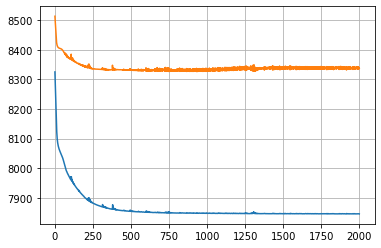

In [330]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
#plt.ylim(7840, 8000)

In [331]:
# Demonstrate recreation
yhat = autoencoder.predict(x=[Input_test[0], mask_test], verbose=1)
yhat_loss = autoencoder.evaluate(x=[Input_test[0], mask_test], y=None, verbose=1)

latent_space = [encoder.predict(Input_train[i], verbose=1) for i in range(3)]

1/1 [==============================] - 0s 16ms/step


(30, 32)
5 4


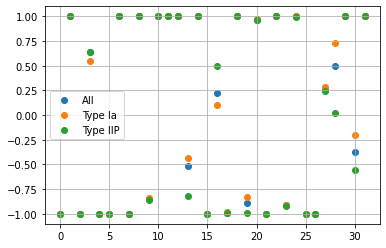

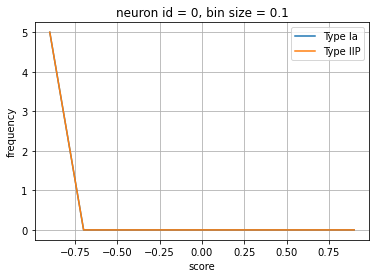

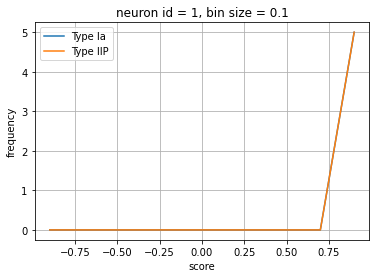

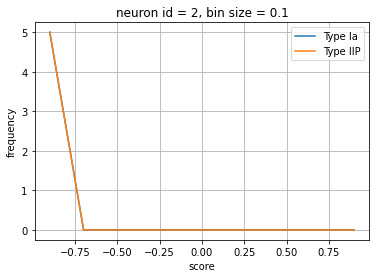

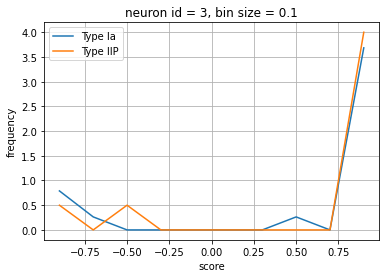

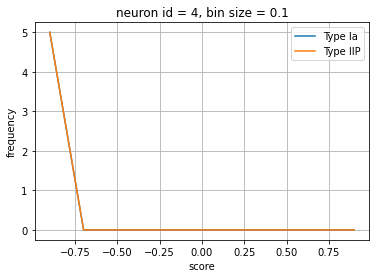

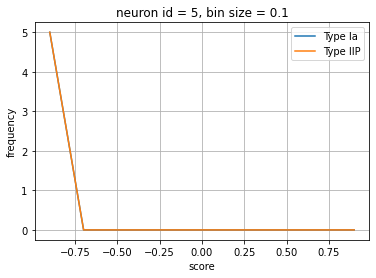

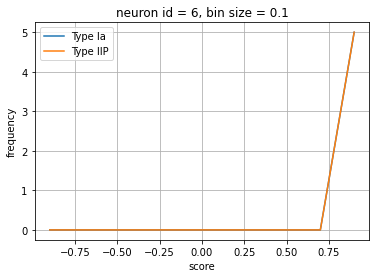

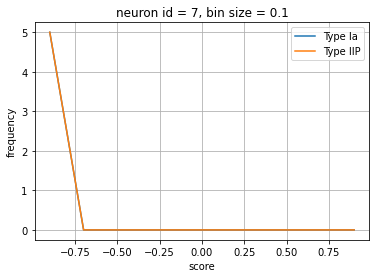

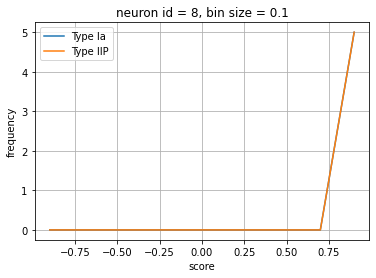

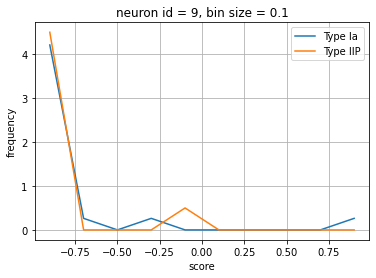

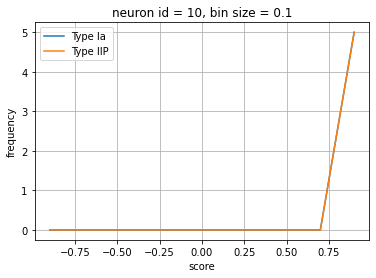

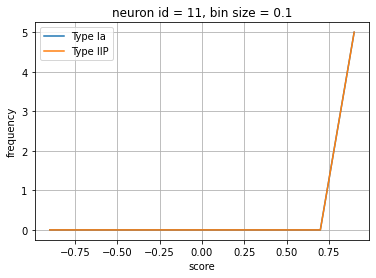

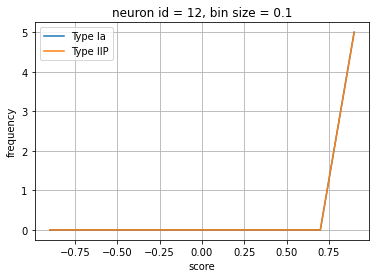

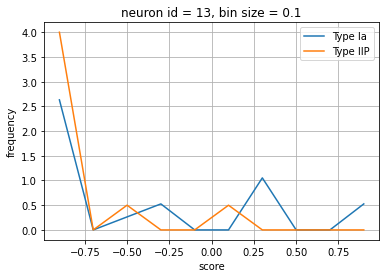

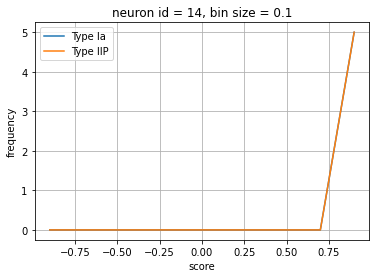

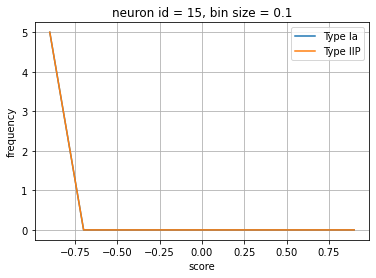

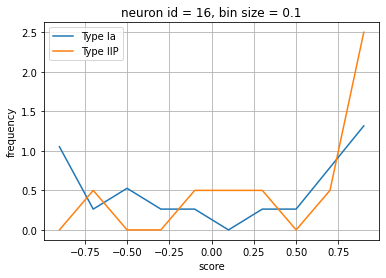

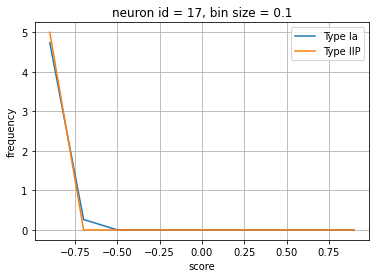

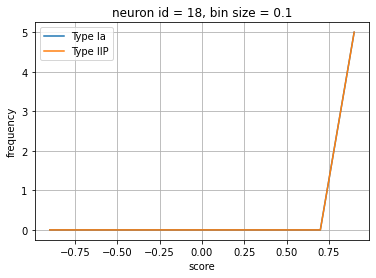

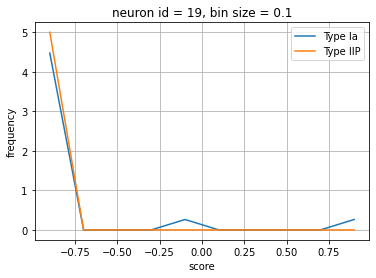

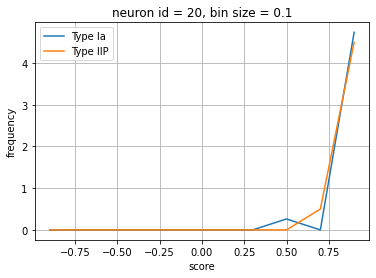

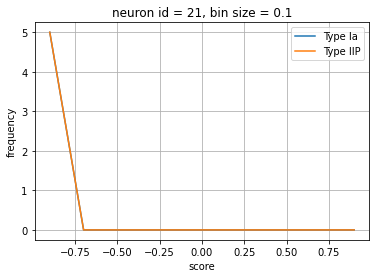

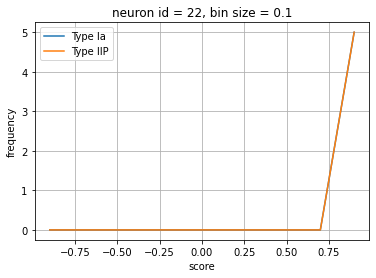

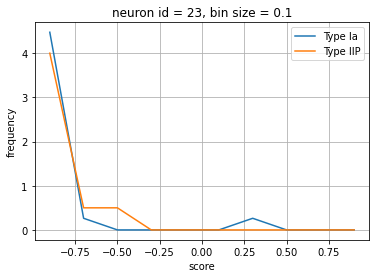

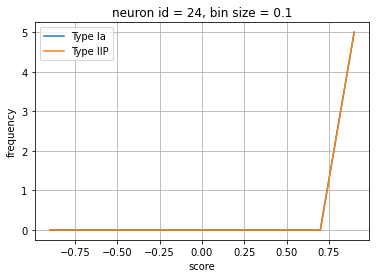

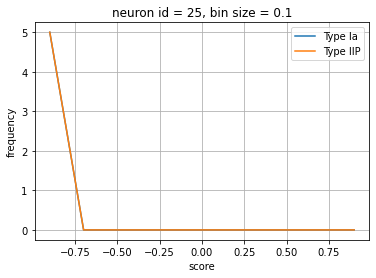

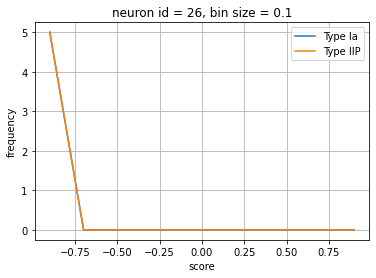

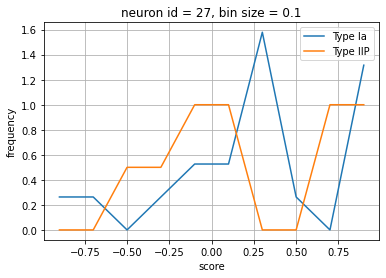

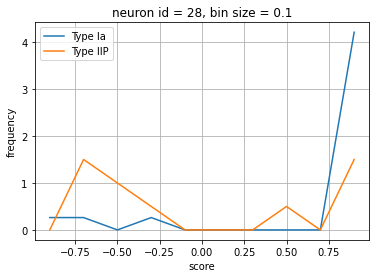

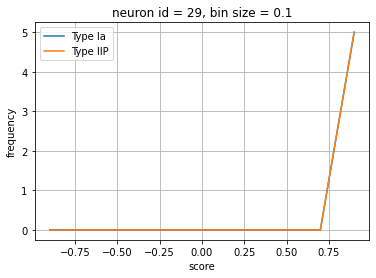

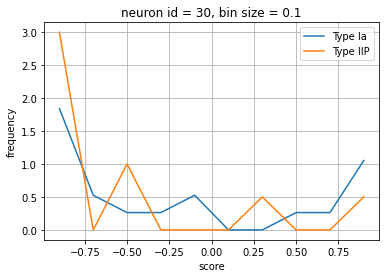

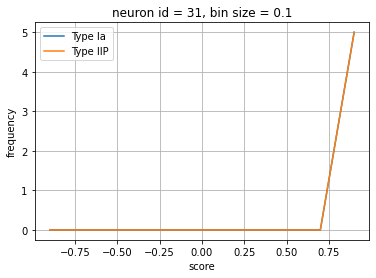

In [332]:
#import shutil
#path = r"C:\Users\ricky\JupyterNotebooks\Intern21\import_photometry_data\all_photometry\latent_spacea_{}".format(latent_space[0].shape[1])
#if os.path.exists(path):
    #shutil.rmtree(path)
#os.mkdir(path)
#os.chdir(path)

print(latent_space[0].shape)

diff = abs((sum(latent_space[1][:]) / latent_space[1].shape[0]) - (sum(latent_space[2][:]) / latent_space[2].shape[0]))
living1 = 0
living2 = 0
for i in range(latent_space[0].shape[1]):
    if diff[i] > 0.1:
        living1 += 1
    if diff[i] > 0.2:
        living2 += 1
print(living1, living2)

'''for i in range(latent_space[0].shape[1] - 1):
    plt.grid()
    plt.scatter(latent_space[1][:,i], latent_space[1][:,i+1])
    plt.scatter(latent_space[2][:,i], latent_space[2][:,i+1])
    plt.show()'''

label = ['All', 'Type Ia', 'Type IIP']

for i in range(3):
    x = np.arange(0, latent_space[i].shape[1], 1)
    y = [sum(latent_space[i][:,j]) / latent_space[i].shape[0] for j in range(latent_space[i].shape[1])]
    plt.scatter(x, y, label=label[i])
    plt.legend()
    plt.grid()
    #plt.savefig('latent_space_sum.jpg', dpi=150)

plt.show()

# x-axis score, y-axis frequency
for i in range(latent_space[0].shape[1]):
    for j in range(2):
        hist, bin_edges = np.histogram(latent_space[j+1][:,i], bins = np.arange(-1, 1.10001, 0.2), density = True)
        bins_mean = [0.5 * (bin_edges[k] + bin_edges[k+1]) for k in range(len(hist))]
        plt.plot(bins_mean, hist, label=label[j+1])
    plt.title('neuron id = {}, bin size = 0.1'.format(i))
    plt.xlabel('score')
    plt.ylabel('frequency')
    plt.legend()
    plt.grid()
    #plt.savefig('neuron id = {}.jpg'.format(i), dpi=150)
    plt.show()

In [333]:
from keras.utils import to_categorical

avg = 0
for i in range(25):
    Type1y = to_categorical(Type1, num_classes=2)
    Type_train_y = to_categorical(Type_train[0], num_classes=2)
    Type_test_y = to_categorical(Type_test[0], num_classes=2)

    x = Dense(128, activation='relu')(encoded)
    classified = Dense(2, activation='softmax')(x)
    classifier = keras.Model(input_seq, classified)

    for l1,l2 in zip(classifier.layers[:], encoder.layers[:]):
        l1.set_weights(l2.get_weights())

    for layer in classifier.layers[:-2]:
        layer.trainable = False
        
    classifier.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    callbacks = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, restore_best_weights=True)
    history = classifier.fit(Input_train[0], Type_train_y, epochs=25)
    
    y = classifier.predict(Input_test[0])
    score = classifier.evaluate(Input_test[0], Type_test_y)
    avg += score[1]

print(Type_test_y - y)
print(int(score[1]*y.shape[0]), y.shape[0])
print(avg/25)

Epoch 1/25
1/1 [==============================] - 8s 8s/step - loss: 0.6598 - accuracy: 0.6667
Epoch 2/25
1/1 [==============================] - 0s 10ms/step - loss: 0.6480 - accuracy: 0.7000
Epoch 3/25
1/1 [==============================] - 0s 11ms/step - loss: 0.5963 - accuracy: 0.7000
Epoch 4/25
1/1 [==============================] - 0s 11ms/step - loss: 0.5616 - accuracy: 0.7000
Epoch 5/25
1/1 [==============================] - 0s 11ms/step - loss: 0.5453 - accuracy: 0.8000
Epoch 6/25
1/1 [==============================] - 0s 11ms/step - loss: 0.5064 - accuracy: 0.7000
Epoch 7/25
1/1 [==============================] - 0s 12ms/step - loss: 0.4919 - accuracy: 0.7000
Epoch 8/25
1/1 [==============================] - 0s 11ms/step - loss: 0.4746 - accuracy: 0.7000
Epoch 9/25
1/1 [==============================] - 0s 11ms/step - loss: 0.4490 - accuracy: 0.8333
Epoch 10/25
1/1 [==============================] - 0s 12ms/step - loss: 0.4424 - accuracy: 0.8667
Epoch 11/25
1/1 [==============

1/1 [==============================] - 0s 11ms/step - loss: 0.3604 - accuracy: 0.8667
Epoch 19/25
1/1 [==============================] - 0s 12ms/step - loss: 0.3502 - accuracy: 0.8667
Epoch 20/25
1/1 [==============================] - 0s 10ms/step - loss: 0.3465 - accuracy: 0.8667
Epoch 21/25
1/1 [==============================] - 0s 11ms/step - loss: 0.3417 - accuracy: 0.8667
Epoch 22/25
1/1 [==============================] - 0s 11ms/step - loss: 0.3332 - accuracy: 0.8667
Epoch 23/25
1/1 [==============================] - 0s 11ms/step - loss: 0.3291 - accuracy: 0.8667
Epoch 24/25
1/1 [==============================] - 0s 10ms/step - loss: 0.3243 - accuracy: 0.8667
Epoch 25/25
1/1 [==============================] - 1s 897ms/step - loss: 0.7570 - accuracy: 0.7692
Epoch 1/25
1/1 [==============================] - 4s 4s/step - loss: 0.6533 - accuracy: 0.7333
Epoch 2/25
1/1 [==============================] - 0s 10ms/step - loss: 0.5685 - accuracy: 0.7000
Epoch 3/25
1/1 [===================

1/1 [==============================] - 1s 947ms/step - loss: 0.7593 - accuracy: 0.7692
Epoch 1/25
1/1 [==============================] - 7s 7s/step - loss: 0.7838 - accuracy: 0.3667
Epoch 2/25
1/1 [==============================] - 0s 10ms/step - loss: 0.6702 - accuracy: 0.7000
Epoch 3/25
1/1 [==============================] - 0s 10ms/step - loss: 0.6730 - accuracy: 0.7000
Epoch 4/25
1/1 [==============================] - 0s 11ms/step - loss: 0.6351 - accuracy: 0.7000
Epoch 5/25
1/1 [==============================] - 0s 11ms/step - loss: 0.5595 - accuracy: 0.7000
Epoch 6/25
1/1 [==============================] - 0s 10ms/step - loss: 0.5255 - accuracy: 0.7333
Epoch 7/25
1/1 [==============================] - 0s 11ms/step - loss: 0.5213 - accuracy: 0.8667
Epoch 8/25
1/1 [==============================] - 0s 11ms/step - loss: 0.4920 - accuracy: 0.8667
Epoch 9/25
1/1 [==============================] - 0s 10ms/step - loss: 0.4631 - accuracy: 0.8000
Epoch 10/25
1/1 [=========================

1/1 [==============================] - 1s 897ms/step - loss: 0.7827 - accuracy: 0.7692
Epoch 1/25
1/1 [==============================] - 4s 4s/step - loss: 0.7116 - accuracy: 0.4667
Epoch 2/25
1/1 [==============================] - 0s 9ms/step - loss: 0.6187 - accuracy: 0.7000
Epoch 3/25
1/1 [==============================] - 0s 11ms/step - loss: 0.6132 - accuracy: 0.7000
Epoch 4/25
1/1 [==============================] - 0s 11ms/step - loss: 0.5759 - accuracy: 0.7000
Epoch 5/25
1/1 [==============================] - 0s 11ms/step - loss: 0.5185 - accuracy: 0.7000
Epoch 6/25
1/1 [==============================] - 0s 10ms/step - loss: 0.5032 - accuracy: 0.8667
Epoch 7/25
1/1 [==============================] - 0s 11ms/step - loss: 0.5076 - accuracy: 0.8667
Epoch 8/25
1/1 [==============================] - 0s 11ms/step - loss: 0.4789 - accuracy: 0.8667
Epoch 9/25
1/1 [==============================] - 0s 10ms/step - loss: 0.4538 - accuracy: 0.8667
Epoch 10/25
1/1 [==========================

1/1 [==============================] - 0s 11ms/step - loss: 0.8490 - accuracy: 0.3000
Epoch 3/25
1/1 [==============================] - 0s 11ms/step - loss: 0.6259 - accuracy: 0.7000
Epoch 4/25
1/1 [==============================] - 0s 11ms/step - loss: 0.6928 - accuracy: 0.7000
Epoch 5/25
1/1 [==============================] - 0s 10ms/step - loss: 0.7847 - accuracy: 0.7000
Epoch 6/25
1/1 [==============================] - 0s 10ms/step - loss: 0.7866 - accuracy: 0.7000
Epoch 7/25
1/1 [==============================] - 0s 10ms/step - loss: 0.7209 - accuracy: 0.7000
Epoch 8/25
1/1 [==============================] - 0s 11ms/step - loss: 0.6322 - accuracy: 0.7000
Epoch 9/25
1/1 [==============================] - 0s 10ms/step - loss: 0.5596 - accuracy: 0.7000
Epoch 10/25
1/1 [==============================] - 0s 11ms/step - loss: 0.5221 - accuracy: 0.6667
Epoch 11/25
1/1 [==============================] - 0s 10ms/step - loss: 0.5222 - accuracy: 0.8667
Epoch 12/25
1/1 [======================

1/1 [==============================] - 0s 11ms/step - loss: 0.4870 - accuracy: 0.8667
Epoch 5/25
1/1 [==============================] - 0s 10ms/step - loss: 0.4685 - accuracy: 0.8667
Epoch 6/25
1/1 [==============================] - 0s 12ms/step - loss: 0.4460 - accuracy: 0.8667
Epoch 7/25
1/1 [==============================] - 0s 11ms/step - loss: 0.4332 - accuracy: 0.8667
Epoch 8/25
1/1 [==============================] - 0s 11ms/step - loss: 0.4141 - accuracy: 0.8667
Epoch 9/25
1/1 [==============================] - 0s 11ms/step - loss: 0.4049 - accuracy: 0.8667
Epoch 10/25
1/1 [==============================] - 0s 11ms/step - loss: 0.3911 - accuracy: 0.8667
Epoch 11/25
1/1 [==============================] - 0s 10ms/step - loss: 0.3826 - accuracy: 0.8667
Epoch 12/25
1/1 [==============================] - 0s 10ms/step - loss: 0.3722 - accuracy: 0.8667
Epoch 13/25
1/1 [==============================] - 0s 11ms/step - loss: 0.3633 - accuracy: 0.8667
Epoch 14/25
1/1 [====================

1/1 [==============================] - 0s 10ms/step - loss: 0.7605 - accuracy: 0.7000
Epoch 7/25
1/1 [==============================] - 0s 9ms/step - loss: 0.6580 - accuracy: 0.7000
Epoch 8/25
1/1 [==============================] - 0s 10ms/step - loss: 0.5514 - accuracy: 0.7000
Epoch 9/25
1/1 [==============================] - 0s 11ms/step - loss: 0.4946 - accuracy: 0.7000
Epoch 10/25
1/1 [==============================] - 0s 9ms/step - loss: 0.5044 - accuracy: 0.8667
Epoch 11/25
1/1 [==============================] - 0s 11ms/step - loss: 0.5441 - accuracy: 0.8000
Epoch 12/25
1/1 [==============================] - 0s 9ms/step - loss: 0.5554 - accuracy: 0.7667
Epoch 13/25
1/1 [==============================] - 0s 9ms/step - loss: 0.5205 - accuracy: 0.8000
Epoch 14/25
1/1 [==============================] - 0s 9ms/step - loss: 0.4686 - accuracy: 0.8667
Epoch 15/25
1/1 [==============================] - 0s 10ms/step - loss: 0.4372 - accuracy: 0.8667
Epoch 16/25
1/1 [=======================

1/1 [==============================] - 0s 10ms/step - loss: 0.6499 - accuracy: 0.7000
Epoch 9/25
1/1 [==============================] - 0s 10ms/step - loss: 0.5726 - accuracy: 0.7000
Epoch 10/25
1/1 [==============================] - 0s 11ms/step - loss: 0.5192 - accuracy: 0.7000
Epoch 11/25
1/1 [==============================] - 0s 10ms/step - loss: 0.5024 - accuracy: 0.7000
Epoch 12/25
1/1 [==============================] - 0s 9ms/step - loss: 0.5129 - accuracy: 0.8667
Epoch 13/25
1/1 [==============================] - 0s 11ms/step - loss: 0.5312 - accuracy: 0.9000
Epoch 14/25
1/1 [==============================] - 0s 11ms/step - loss: 0.5385 - accuracy: 0.8667
Epoch 15/25
1/1 [==============================] - 0s 11ms/step - loss: 0.5275 - accuracy: 0.8667
Epoch 16/25
1/1 [==============================] - 0s 11ms/step - loss: 0.5026 - accuracy: 0.9000
Epoch 17/25
1/1 [==============================] - 0s 12ms/step - loss: 0.4741 - accuracy: 0.8667
Epoch 18/25
1/1 [=================

1/1 [==============================] - 0s 11ms/step - loss: 0.4497 - accuracy: 0.8667
Epoch 11/25
1/1 [==============================] - 0s 12ms/step - loss: 0.4399 - accuracy: 0.8667
Epoch 12/25
1/1 [==============================] - 0s 12ms/step - loss: 0.4454 - accuracy: 0.8000
Epoch 13/25
1/1 [==============================] - 0s 11ms/step - loss: 0.4334 - accuracy: 0.8000
Epoch 14/25
1/1 [==============================] - 0s 11ms/step - loss: 0.4092 - accuracy: 0.8667
Epoch 15/25
1/1 [==============================] - 0s 12ms/step - loss: 0.3985 - accuracy: 0.8667
Epoch 16/25
1/1 [==============================] - 0s 12ms/step - loss: 0.4010 - accuracy: 0.8667
Epoch 17/25
1/1 [==============================] - 0s 11ms/step - loss: 0.3960 - accuracy: 0.8667
Epoch 18/25
1/1 [==============================] - 0s 11ms/step - loss: 0.3808 - accuracy: 0.8667
Epoch 19/25
1/1 [==============================] - 0s 12ms/step - loss: 0.3724 - accuracy: 0.8667
Epoch 20/25
1/1 [===============

1/1 [==============================] - 0s 11ms/step - loss: 0.4026 - accuracy: 0.8667
Epoch 13/25
1/1 [==============================] - 0s 11ms/step - loss: 0.3871 - accuracy: 0.8667
Epoch 14/25
1/1 [==============================] - 0s 11ms/step - loss: 0.3791 - accuracy: 0.8667
Epoch 15/25
1/1 [==============================] - 0s 11ms/step - loss: 0.3746 - accuracy: 0.8667
Epoch 16/25
1/1 [==============================] - 0s 11ms/step - loss: 0.3617 - accuracy: 0.8667
Epoch 17/25
1/1 [==============================] - 0s 11ms/step - loss: 0.3563 - accuracy: 0.8667
Epoch 18/25
1/1 [==============================] - 0s 11ms/step - loss: 0.3506 - accuracy: 0.8667
Epoch 19/25
1/1 [==============================] - 0s 9ms/step - loss: 0.3403 - accuracy: 0.8667
Epoch 20/25
1/1 [==============================] - 0s 10ms/step - loss: 0.3366 - accuracy: 0.8667
Epoch 21/25
1/1 [==============================] - 0s 10ms/step - loss: 0.3299 - accuracy: 0.8667
Epoch 22/25
1/1 [================

1/1 [==============================] - 0s 11ms/step - loss: 0.4205 - accuracy: 0.8667
Epoch 15/25
1/1 [==============================] - 0s 11ms/step - loss: 0.4213 - accuracy: 0.8667
Epoch 16/25
1/1 [==============================] - 0s 10ms/step - loss: 0.4075 - accuracy: 0.8667
Epoch 17/25
1/1 [==============================] - 0s 11ms/step - loss: 0.3906 - accuracy: 0.8667
Epoch 18/25
1/1 [==============================] - 0s 11ms/step - loss: 0.3866 - accuracy: 0.8667
Epoch 19/25
1/1 [==============================] - 0s 11ms/step - loss: 0.3858 - accuracy: 0.8667
Epoch 20/25
1/1 [==============================] - 0s 9ms/step - loss: 0.3774 - accuracy: 0.8667
Epoch 21/25
1/1 [==============================] - 0s 10ms/step - loss: 0.3658 - accuracy: 0.8667
Epoch 22/25
1/1 [==============================] - 0s 11ms/step - loss: 0.3608 - accuracy: 0.8667
Epoch 23/25
1/1 [==============================] - 0s 10ms/step - loss: 0.3599 - accuracy: 0.8667
Epoch 24/25
1/1 [================

1/1 [==============================] - 0s 12ms/step - loss: 0.4306 - accuracy: 0.8667
Epoch 17/25
1/1 [==============================] - 0s 10ms/step - loss: 0.4380 - accuracy: 0.7333
Epoch 18/25
1/1 [==============================] - 0s 10ms/step - loss: 0.4388 - accuracy: 0.7333
Epoch 19/25
1/1 [==============================] - 0s 11ms/step - loss: 0.4288 - accuracy: 0.8667
Epoch 20/25
1/1 [==============================] - 0s 11ms/step - loss: 0.4135 - accuracy: 0.8667
Epoch 21/25
1/1 [==============================] - 0s 11ms/step - loss: 0.4006 - accuracy: 0.8667
Epoch 22/25
1/1 [==============================] - 0s 10ms/step - loss: 0.3951 - accuracy: 0.8667
Epoch 23/25
1/1 [==============================] - 0s 11ms/step - loss: 0.3952 - accuracy: 0.8667
Epoch 24/25
1/1 [==============================] - 0s 11ms/step - loss: 0.3965 - accuracy: 0.8667
Epoch 25/25
1/1 [==============================] - 1s 942ms/step - loss: 0.6817 - accuracy: 0.6923
Epoch 1/25
1/1 [===============

In [334]:
print(Input[0].shape, Type1y.shape, input_seq.shape)

avg = 0
for i in range(25):
    x = Flatten()(input_seq)
    x = Dense(128, activation='relu')(x)
    classified = Dense(2, activation='softmax')(x)
    classifier1 = keras.Model(input_seq, classified)
    
    classifier1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    callbacks = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, restore_best_weights=True)
    history = classifier1.fit(Input_train[0], Type_train_y, epochs=25)
    
    y = classifier1.predict(Input_test[0])
    score = classifier1.evaluate(Input_test[0], Type_test_y)
    avg += score[1]

print(Type_test_y - y)
print(int(score[1]*y.shape[0]), y.shape[0])
print(avg/25)

(43, 130, 2) (43, 2) (None, 130, 2)
Epoch 1/25
1/1 [==============================] - 0s 241ms/step - loss: 10.9383 - accuracy: 0.7000
Epoch 2/25
1/1 [==============================] - 0s 4ms/step - loss: 201.0544 - accuracy: 0.3000
Epoch 3/25
1/1 [==============================] - 0s 3ms/step - loss: 53.6753 - accuracy: 0.3000
Epoch 4/25
1/1 [==============================] - 0s 3ms/step - loss: 63.8129 - accuracy: 0.7000
Epoch 5/25
1/1 [==============================] - 0s 3ms/step - loss: 104.5174 - accuracy: 0.7000
Epoch 6/25
1/1 [==============================] - 0s 4ms/step - loss: 116.7750 - accuracy: 0.7000
Epoch 7/25
1/1 [==============================] - 0s 3ms/step - loss: 111.3567 - accuracy: 0.7000
Epoch 8/25
1/1 [==============================] - 0s 3ms/step - loss: 93.4289 - accuracy: 0.7000
Epoch 9/25
1/1 [==============================] - 0s 3ms/step - loss: 66.9238 - accuracy: 0.7000
Epoch 10/25
1/1 [==============================] - 0s 4ms/step - loss: 35.6464 - accu

1/1 [==============================] - 0s 3ms/step - loss: 171.9677 - accuracy: 0.3000
Epoch 3/25
1/1 [==============================] - 0s 3ms/step - loss: 18.4205 - accuracy: 0.3000
Epoch 4/25
1/1 [==============================] - 0s 4ms/step - loss: 97.6861 - accuracy: 0.7000
Epoch 5/25
1/1 [==============================] - 0s 3ms/step - loss: 146.4689 - accuracy: 0.7000
Epoch 6/25
1/1 [==============================] - 0s 3ms/step - loss: 158.7451 - accuracy: 0.7000
Epoch 7/25
1/1 [==============================] - 0s 3ms/step - loss: 148.3469 - accuracy: 0.7000
Epoch 8/25
1/1 [==============================] - 0s 3ms/step - loss: 120.7308 - accuracy: 0.7000
Epoch 9/25
1/1 [==============================] - 0s 3ms/step - loss: 81.7735 - accuracy: 0.7000
Epoch 10/25
1/1 [==============================] - 0s 3ms/step - loss: 38.6715 - accuracy: 0.7000
Epoch 11/25
1/1 [==============================] - 0s 3ms/step - loss: 13.6134 - accuracy: 0.4000
Epoch 12/25
1/1 [=================

1/1 [==============================] - 0s 2ms/step - loss: 32.9903 - accuracy: 0.7000
Epoch 4/25
1/1 [==============================] - 0s 3ms/step - loss: 61.9412 - accuracy: 0.7000
Epoch 5/25
1/1 [==============================] - 0s 3ms/step - loss: 50.8843 - accuracy: 0.7000
Epoch 6/25
1/1 [==============================] - 0s 3ms/step - loss: 13.5942 - accuracy: 0.7000
Epoch 7/25
1/1 [==============================] - 0s 4ms/step - loss: 87.6568 - accuracy: 0.3000
Epoch 8/25
1/1 [==============================] - 0s 3ms/step - loss: 62.6278 - accuracy: 0.3333
Epoch 9/25
1/1 [==============================] - 0s 3ms/step - loss: 14.4633 - accuracy: 0.7000
Epoch 10/25
1/1 [==============================] - 0s 3ms/step - loss: 37.3110 - accuracy: 0.7000
Epoch 11/25
1/1 [==============================] - 0s 3ms/step - loss: 41.3094 - accuracy: 0.7000
Epoch 12/25
1/1 [==============================] - 0s 3ms/step - loss: 30.3479 - accuracy: 0.7000
Epoch 13/25
1/1 [=====================

1/1 [==============================] - 0s 4ms/step - loss: 119.3643 - accuracy: 0.7000
Epoch 5/25
1/1 [==============================] - 0s 3ms/step - loss: 80.0245 - accuracy: 0.7000
Epoch 6/25
1/1 [==============================] - 0s 4ms/step - loss: 33.8704 - accuracy: 0.7000
Epoch 7/25
1/1 [==============================] - 0s 3ms/step - loss: 35.2005 - accuracy: 0.3000
Epoch 8/25
1/1 [==============================] - 0s 3ms/step - loss: 41.7630 - accuracy: 0.3000
Epoch 9/25
1/1 [==============================] - 0s 3ms/step - loss: 2.3126 - accuracy: 0.6667
Epoch 10/25
1/1 [==============================] - 0s 3ms/step - loss: 14.2786 - accuracy: 0.7000
Epoch 11/25
1/1 [==============================] - 0s 3ms/step - loss: 15.2703 - accuracy: 0.7000
Epoch 12/25
1/1 [==============================] - 0s 3ms/step - loss: 8.7938 - accuracy: 0.7000
Epoch 13/25
1/1 [==============================] - 0s 3ms/step - loss: 3.9589 - accuracy: 0.6667
Epoch 14/25
1/1 [======================

1/1 [==============================] - 0s 3ms/step - loss: 35.0031 - accuracy: 0.3000
Epoch 7/25
1/1 [==============================] - 0s 3ms/step - loss: 16.8372 - accuracy: 0.7000
Epoch 8/25
1/1 [==============================] - 0s 3ms/step - loss: 20.0975 - accuracy: 0.7000
Epoch 9/25
1/1 [==============================] - 0s 3ms/step - loss: 8.9428 - accuracy: 0.6667
Epoch 10/25
1/1 [==============================] - 0s 3ms/step - loss: 9.7628 - accuracy: 0.6000
Epoch 11/25
1/1 [==============================] - 0s 3ms/step - loss: 15.3061 - accuracy: 0.7000
Epoch 12/25
1/1 [==============================] - 0s 3ms/step - loss: 10.2498 - accuracy: 0.7000
Epoch 13/25
1/1 [==============================] - 0s 4ms/step - loss: 23.2080 - accuracy: 0.4333
Epoch 14/25
1/1 [==============================] - 0s 3ms/step - loss: 4.1570 - accuracy: 0.8000
Epoch 15/25
1/1 [==============================] - 0s 3ms/step - loss: 15.7471 - accuracy: 0.7000
Epoch 16/25
1/1 [=====================

Epoch 8/25
1/1 [==============================] - 0s 3ms/step - loss: 82.3054 - accuracy: 0.3000
Epoch 9/25
1/1 [==============================] - 0s 3ms/step - loss: 7.5043 - accuracy: 0.5667
Epoch 10/25
1/1 [==============================] - 0s 3ms/step - loss: 44.3844 - accuracy: 0.7000
Epoch 11/25
1/1 [==============================] - 0s 3ms/step - loss: 73.3082 - accuracy: 0.7000
Epoch 12/25
1/1 [==============================] - 0s 3ms/step - loss: 84.5860 - accuracy: 0.7000
Epoch 13/25
1/1 [==============================] - 0s 2ms/step - loss: 81.4257 - accuracy: 0.7000
Epoch 14/25
1/1 [==============================] - 0s 3ms/step - loss: 67.1304 - accuracy: 0.7000
Epoch 15/25
1/1 [==============================] - 0s 2ms/step - loss: 44.4117 - accuracy: 0.7000
Epoch 16/25
1/1 [==============================] - 0s 3ms/step - loss: 15.7775 - accuracy: 0.7000
Epoch 17/25
1/1 [==============================] - 0s 4ms/step - loss: 26.6378 - accuracy: 0.3667
Epoch 18/25
1/1 [======

1/1 [==============================] - 0s 3ms/step - loss: 101.3413 - accuracy: 0.7000
Epoch 10/25
1/1 [==============================] - 0s 3ms/step - loss: 47.8248 - accuracy: 0.7000
Epoch 11/25
1/1 [==============================] - 0s 3ms/step - loss: 13.6603 - accuracy: 0.5000
Epoch 12/25
1/1 [==============================] - 0s 3ms/step - loss: 54.1779 - accuracy: 0.3333
Epoch 13/25
1/1 [==============================] - 0s 4ms/step - loss: 31.6881 - accuracy: 0.3333
Epoch 14/25
1/1 [==============================] - 0s 3ms/step - loss: 9.5448 - accuracy: 0.7000
Epoch 15/25
1/1 [==============================] - 0s 3ms/step - loss: 24.6313 - accuracy: 0.7000
Epoch 16/25
1/1 [==============================] - 0s 3ms/step - loss: 28.8205 - accuracy: 0.7000
Epoch 17/25
1/1 [==============================] - 0s 3ms/step - loss: 24.2671 - accuracy: 0.7000
Epoch 18/25
1/1 [==============================] - 0s 5ms/step - loss: 12.8206 - accuracy: 0.7000
Epoch 19/25
1/1 [===============

1/1 [==============================] - 0s 3ms/step - loss: 5.6802 - accuracy: 0.5667
Epoch 11/25
1/1 [==============================] - 0s 3ms/step - loss: 16.4524 - accuracy: 0.5000
Epoch 12/25
1/1 [==============================] - 0s 4ms/step - loss: 12.7046 - accuracy: 0.7000
Epoch 13/25
1/1 [==============================] - 0s 3ms/step - loss: 13.6633 - accuracy: 0.7000
Epoch 14/25
1/1 [==============================] - 0s 5ms/step - loss: 4.0172 - accuracy: 0.7667
Epoch 15/25
1/1 [==============================] - 0s 3ms/step - loss: 3.7215 - accuracy: 0.7000
Epoch 16/25
1/1 [==============================] - 0s 3ms/step - loss: 11.8260 - accuracy: 0.7000
Epoch 17/25
1/1 [==============================] - 0s 4ms/step - loss: 9.4720 - accuracy: 0.7000
Epoch 18/25
1/1 [==============================] - 0s 3ms/step - loss: 7.8601 - accuracy: 0.4333
Epoch 19/25
1/1 [==============================] - 0s 4ms/step - loss: 4.5123 - accuracy: 0.7333
Epoch 20/25
1/1 [=====================

1/1 [==============================] - 0s 4ms/step - loss: 43.6962 - accuracy: 0.7000
Epoch 13/25
1/1 [==============================] - 0s 2ms/step - loss: 31.5902 - accuracy: 0.7000
Epoch 14/25
1/1 [==============================] - 0s 3ms/step - loss: 10.7358 - accuracy: 0.7000
Epoch 15/25
1/1 [==============================] - 0s 3ms/step - loss: 31.8923 - accuracy: 0.3000
Epoch 16/25
1/1 [==============================] - 0s 3ms/step - loss: 37.1309 - accuracy: 0.3333
Epoch 17/25
1/1 [==============================] - 0s 4ms/step - loss: 5.6046 - accuracy: 0.5667
Epoch 18/25
1/1 [==============================] - 0s 3ms/step - loss: 18.8072 - accuracy: 0.7000
Epoch 19/25
1/1 [==============================] - 0s 3ms/step - loss: 30.3779 - accuracy: 0.7000
Epoch 20/25
1/1 [==============================] - 0s 4ms/step - loss: 33.5557 - accuracy: 0.7000
Epoch 21/25
1/1 [==============================] - 0s 3ms/step - loss: 30.2423 - accuracy: 0.7000
Epoch 22/25
1/1 [================

1/1 [==============================] - 0s 4ms/step - loss: 10.5167 - accuracy: 0.4333
Epoch 14/25
1/1 [==============================] - 0s 3ms/step - loss: 4.2273 - accuracy: 0.7333
Epoch 15/25
1/1 [==============================] - 0s 3ms/step - loss: 6.1298 - accuracy: 0.7000
Epoch 16/25
1/1 [==============================] - 0s 3ms/step - loss: 2.2619 - accuracy: 0.8000
Epoch 17/25
1/1 [==============================] - 0s 3ms/step - loss: 5.8266 - accuracy: 0.5000
Epoch 18/25
1/1 [==============================] - 0s 3ms/step - loss: 3.6427 - accuracy: 0.7333
Epoch 19/25
1/1 [==============================] - 0s 3ms/step - loss: 4.6992 - accuracy: 0.7000
Epoch 20/25
1/1 [==============================] - 0s 3ms/step - loss: 1.2311 - accuracy: 0.8333
Epoch 21/25
1/1 [==============================] - 0s 3ms/step - loss: 5.9264 - accuracy: 0.4333
Epoch 22/25
1/1 [==============================] - 0s 3ms/step - loss: 2.6817 - accuracy: 0.7333
Epoch 23/25
1/1 [========================

Epoch 15/25
1/1 [==============================] - 0s 3ms/step - loss: 7.8609 - accuracy: 0.7000
Epoch 16/25
1/1 [==============================] - 0s 3ms/step - loss: 19.7682 - accuracy: 0.7000
Epoch 17/25
1/1 [==============================] - 0s 3ms/step - loss: 25.7994 - accuracy: 0.7000
Epoch 18/25
1/1 [==============================] - 0s 3ms/step - loss: 26.9701 - accuracy: 0.7000
Epoch 19/25
1/1 [==============================] - 0s 4ms/step - loss: 24.4588 - accuracy: 0.7000
Epoch 20/25
1/1 [==============================] - 0s 3ms/step - loss: 19.1147 - accuracy: 0.7000
Epoch 21/25
1/1 [==============================] - 0s 3ms/step - loss: 11.6597 - accuracy: 0.7000
Epoch 22/25
1/1 [==============================] - 0s 3ms/step - loss: 3.0152 - accuracy: 0.6667
Epoch 23/25
1/1 [==============================] - 0s 3ms/step - loss: 10.4619 - accuracy: 0.4000
Epoch 24/25
1/1 [==============================] - 0s 3ms/step - loss: 16.4468 - accuracy: 0.3333
Epoch 25/25
1/1 [=====

1/1 [==============================] - 0s 3ms/step - loss: 45.6439 - accuracy: 0.3000
Epoch 17/25
1/1 [==============================] - 0s 2ms/step - loss: 4.0693 - accuracy: 0.7667
Epoch 18/25
1/1 [==============================] - 0s 3ms/step - loss: 21.6411 - accuracy: 0.7000
Epoch 19/25
1/1 [==============================] - 0s 3ms/step - loss: 32.9417 - accuracy: 0.7000
Epoch 20/25
1/1 [==============================] - 0s 3ms/step - loss: 35.2700 - accuracy: 0.7000
Epoch 21/25
1/1 [==============================] - 0s 3ms/step - loss: 30.3744 - accuracy: 0.7000
Epoch 22/25
1/1 [==============================] - 0s 3ms/step - loss: 19.5723 - accuracy: 0.7000
Epoch 23/25
1/1 [==============================] - 0s 3ms/step - loss: 4.9260 - accuracy: 0.6667
Epoch 24/25
1/1 [==============================] - 0s 3ms/step - loss: 17.5321 - accuracy: 0.4667
Epoch 25/25
1/1 [==============================] - 0s 88ms/step - loss: 10.4230 - accuracy: 0.3846
Epoch 1/25
1/1 [=================

1/1 [==============================] - 0s 3ms/step - loss: 6.2871 - accuracy: 0.7000
Epoch 18/25
1/1 [==============================] - 0s 3ms/step - loss: 15.8054 - accuracy: 0.7000
Epoch 19/25
1/1 [==============================] - 0s 3ms/step - loss: 21.2652 - accuracy: 0.7000
Epoch 20/25
1/1 [==============================] - 0s 3ms/step - loss: 23.3685 - accuracy: 0.7000
Epoch 21/25
1/1 [==============================] - 0s 2ms/step - loss: 22.7017 - accuracy: 0.7000
Epoch 22/25
1/1 [==============================] - 0s 3ms/step - loss: 19.7731 - accuracy: 0.7000
Epoch 23/25
1/1 [==============================] - 0s 3ms/step - loss: 15.0518 - accuracy: 0.7000
Epoch 24/25
1/1 [==============================] - 0s 3ms/step - loss: 8.8982 - accuracy: 0.7000
Epoch 25/25
1/1 [==============================] - 0s 89ms/step - loss: 6.9628 - accuracy: 0.4615
[[-1.1746449e-05  1.1801720e-05]
 [ 9.9793065e-01 -9.9793065e-01]
 [ 1.0000000e+00 -1.0000000e+00]
 [-2.1940511e-01  2.1940511e-01]


In [335]:
from sklearn import manifold

latent_space = np.array(latent_space)
x = manifold.TSNE(n_components = 2).fit_transform(latent_space)
print(x.shape)

x_min, x_max = x.min(0), x.max(0)
x_norm = (x - x_min) / (x_max - x_min)

plt.figure(figsize=(8, 8))
for i in range(x_norm.shape[0]):
    plt.text(x_norm[i, 0], x_norm[i, 1], str(y[i]), color=plt.cm.Set1(y[i]), 
             fontdict={'weight': 'bold', 'size': 9})

<ipython-input-335-27e8462aade9>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  latent_space = np.array(latent_space)


ValueError: setting an array element with a sequence.

In [ ]:
#import shutil
#path = r"C:\Users\ricky\JupyterNotebooks\Intern21\import_photometry_data\all_photometry\data_test_physical_length100_shifteda_{}".format(lightcurve_length_max)
#if os.path.exists(path):
    #shutil.rmtree(path)
#os.mkdir(path)
#os.chdir(path)

for i in range(Input_test[0].shape[0]):
    fig = plt.figure(figsize=(12.8,8))
    ax = fig.add_subplot(1, 1, 1)

    plt.gca().invert_yaxis()

    # And a corresponding grid
    ax.grid(which='major', alpha=0.8)
    ax.grid(which='minor', alpha=0.3)

    plt.xlabel('Timestep')
    plt.ylabel('Absolute Magnitude')
    
    plt.ylim(-10, -21)

    '''x = np.linspace(1, lightcurve_length_max, lightcurve_length_max)

    plt.scatter(x, lightcurve_test[i,:,0], s=2)
    plt.scatter(x, yhat[i,:,0], s=2)'''
    
    plt.scatter(Input_test[0][i,:,0], Input_test[0][i,:,1], s=2, label='test data')
    plt.scatter(yhat[i,:,0], yhat[i,:,1], s=2, label='reconstruction')
    
    plt.legend()
        
    print('the claimed type is', Type[lightcurve_succ[i+split]]) # This line is incorrect for now
    #plt.savefig('{}.jpg'.format(i), dpi = 150)    
    plt.show()

In [ ]:
# Philips relation

from sklearn.metrics import r2_score
M = []
dm_P = []

fitting_days = 15

for i in range(Input_test[0].shape[0]): # Loop through all SN
    maximum = np.argmin(yhat[i,:,1]) # Find the id of maximum magnitude
    peak_time = yhat[i,maximum,0] # Save the day of maximum magnitude
    tail_time = yhat[i,maximum,0] # Save the day of the end of the initial lightcurve fall off
        
        # Calculate the day of the end of the initial lightcurve fall off
    j = 0
    if (peak_time + fitting_days) < yhat[i,-1,0]: # Avoid light curve that is too short (fewer than 15 days after the peak)
        while tail_time < (peak_time + fitting_days):
            tail_time = yhat[i,maximum+j,0]
            if tail_time > (peak_time + fitting_days):
                break
            j += 1
        
        # Save the peaking part of the light curve
        t = yhat[i,0:maximum+j,0]
        m = yhat[i,0:maximum+j,1]
        
        # Polynomial (degree = 3) fit of the peak part of the light curve 
        P = np.poly1d(np.polyfit(t, m, deg = 3))
        P_max = (-1*P[2] + ((P[2])**2 - 3*P[3]*P[1])**(1/2))/(3*P[3])
        
        M.append(P(P_max))
        dm_P.append(P(P_max + 15) - P(P_max))

#P1 = np.poly1d(np.polyfit(dm_P, M, deg = 1))
P1 = np.poly1d(np.polyfit(dm_P, M, deg = 1))
print(P1)
print(r2_score(M, P1(dm_P)))

# Plot out the linear relationship
plt.gca().invert_yaxis()
plt.xlabel('$\Delta m_{15}$')
plt.ylabel('Maximum absolute magnitude, $M_{max}$')
plt.grid()
x = np.linspace(0, 2, 100)
plt.scatter(x, P1(x), s=3)
plt.scatter(dm_P, M, s=3)